Задача - multi-label классификация - освежить память что это значит (https://scikit-learn.org/stable/modules/multiclass.html).

Тартеты: 14 последних колонок - df.iloc[:,-14:]

Метрика: Micro averaged F1. Хорошо бы оценивать качество с помощью кросс-валидации.

- Построить baseline с использованием линейной модели из scikit-learn


- Чистый Tensorflow

Построить линейную модель для решения этой задачи. Можно взять существующий код из блокнота Tensorflow examples 1.ipynb и переделать.


- Keras

Сделать тоже самое как и в Tensorflow но использовав чистый Keras

Добавить слоёв и нелинейностей, сравнить качество моделей


In [1]:
!pip install --upgrade pandas
!pip install --upgrade scikit-learn
!pip install --upgrade inflect
!pip install --upgrade seaborn
!pip install --upgrade pprint
!pip install --upgrade tensorflow
#!pip install --upgrade contractions
#!pip install --upgrade wordcloud
#!pip install --upgrade umap-learn
#!pip install --upgrade gensim
#!pip install --upgrade pyldavis

Requirement already up-to-date: pandas in c:\anaconda\lib\site-packages (0.24.0)
Requirement already up-to-date: scikit-learn in c:\anaconda\lib\site-packages (0.20.2)
Requirement already up-to-date: inflect in c:\anaconda\lib\site-packages (2.1.0)
Requirement already up-to-date: seaborn in c:\anaconda\lib\site-packages (0.9.0)
Requirement already up-to-date: pprint in c:\anaconda\lib\site-packages (0.1)
Requirement already up-to-date: tensorflow in c:\anaconda\lib\site-packages (1.12.0)


In [2]:
#common libs
import numpy as np
import pandas as pd
import scipy.stats as st
from matplotlib import pyplot as plt
import seaborn as sns

import re
import string
import inflect
import itertools
from pprint import pprint
from tqdm import tqdm
from time import time
from itertools import compress
from collections import Counter
#import glob
#import contractions
#from wordcloud import WordCloud
#import umap
#import unicodedata
#from bs4 import BeautifulSoup

#import time

#from scipy import interp

import pickle
sns.set(font_scale=1.3)

seed = 321

%matplotlib inline

In [3]:
#sklearn libs
from sklearn.preprocessing import label_binarize,MultiLabelBinarizer,StandardScaler
from sklearn.pipeline import make_pipeline,Pipeline

from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.cluster import KMeans,DBSCAN

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split 
from sklearn.model_selection import KFold,RandomizedSearchCV, cross_val_score

from sklearn.multiclass import OneVsRestClassifier

from sklearn.metrics import confusion_matrix, classification_report,f1_score, make_scorer
from sklearn.metrics import homogeneity_score,completeness_score, v_measure_score
from sklearn.metrics import adjusted_rand_score,adjusted_mutual_info_score,silhouette_score
from sklearn.manifold import TSNE

from sklearn.decomposition import TruncatedSVD

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

In [4]:
import tensorflow as tf

In [5]:
import keras
import json
import operator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.metrics import binary_accuracy,categorical_accuracy
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import model_from_json

Using TensorFlow backend.


In [6]:
import nltk
nltk.download('punkt')
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('names')

from nltk.corpus import names
from nltk.corpus import stopwords
from nltk import ngrams

from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer # one more stemmer? or lemmatisation
from nltk.stem import WordNetLemmatizer,LancasterStemmer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chief\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chief\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\chief\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package names to
[nltk_data]     C:\Users\chief\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!


#### EDA.

read first ten row to understand, how to parse data.

In [7]:
x_data, y_data = pickle.load(open('data/task_2/reviews_dataset.pkl', 'rb'))

In [8]:
len(x_data)

769251

In [9]:
len(y_data)

769251

In [10]:
x_data[0]

'Потрясающе красивая графика космоса! Уже за это игру можно полюбить. Так же в наличии интересный осмысленный сюжет и удобное управление.'

In [11]:
y_data[0]

5

Baseline.

Обучить линейную модель на TF-IDF представлении для предсказания оценки пользователя по его отзыву. 

Посмотреть на важность для каждой оценки.

In [12]:
def remove_emails(text):
    text = re.sub(r'\S*@\S*\s?','',text)    
    return text


#version on raw text
def remove_punctuation2(text_punctuation,text):
    
    new_text = []
    new_text = re.sub('\n', ' ',text)
    new_text = re.sub('\t', '',new_text)
    new_text = re.sub('['+text_punctuation+']', ' ',new_text)
    new_text =  new_text.strip()
    
    return new_text

#version after word_tokenizer
def remove_punctuation(text_punctuation,text):
    
    new_text = []
    for word in text: 
        new_word =  re.sub('['+text_punctuation+']', ' ',word)
        new_word =  new_word.strip()
        new_text.append(new_word)
    
    return new_text


#ntlk word lemmatizer
def lemmatize_stemm_text(text):
    new_text_lemma = []
    new_text_stemm = []
    
    lemmatizer = WordNetLemmatizer()
    stemmer = LancasterStemmer()
    
    for word in text:
        lemma = lemmatizer.lemmatize(word, pos='n') # v default
        new_text_lemma.append(lemma)
        
        #stemm = stemmer.stem(word)
        #new_text_stemm.append(stemm)
        
    return new_text_lemma, new_text_stemm
        

StopWords = list(set(stopwords.words('russian')))
'''
StopWords = list(set( stopwords.words('english') ).union( set(ENGLISH_STOP_WORDS)))
newStopWords = ['jfc','jb'] # по ходу работы периодически добавляем стоп-слова
newStopWords2 = ['arent', 'didnt', 'doesnt', 'dont', 'hadnt', 'havent', 'isnt', 
                 'mightnt', 'mustnt', 'neednt', 'shant', 'shes', 'shouldnt', 'shouldve', 'theres','thatll', 'wasnt', 
                 'werent', 'wont', 'wouldnt', 'youd', 'youll', 'youre', 'youve',
                 "'ll", "'re", "'ve", "n't", 'need', 'sha', 'anna','n t','ann mari', 'ann marie', 
                 'anna diana', 'anna diane', 'anna maria', 'anne corinne', 'anne mar', 'anne marie', 
                 'barbara anne', 'bette ann', 'carol jean', 'diane marie', 'e lane', 'hans peter', 
                 'helen elizabeth', 'holly anne', 'jean christophe', 'jean francois', 'jean lou', 
                 'jean luc', 'jean marc', 'jean paul', 'jean pierre', 'jo anne', 'john david', 'john patrick', 
                 'kara lynn', 'marie ann', 'marie jeanne', 'paula grace', 'sara ann', 
                 'sheila kathryn', 'sue elle', 'terri jo', 'theresa marie','sza']

#StopWords.extend(newStopWords)
#StopWords.extend(newStopWords2)


male_names = names.words('male.txt')
female_names = names.words('female.txt')

Common_First_Names = list(set(male_names).union(set(female_names)))
Common_First_Names = list(map(lambda word: word.lower(), Common_First_Names))
# temporaly disabled to reduce tfidf time
#StopWords.extend(Common_First_Names) ''';

def remove_stopwords(stop_words ,text):
    
    new_words = []
    for word in text:
        if word not in stop_words:
            new_words.append(word)

    return new_words

def remove_short_words(text, word_len):
    new_text = []
    for word in text:
        if len(word) >= word_len:
            new_text.append(word)
            
    return new_text


# getting source from string.punctuation
text_punctuation = '!"#$%&\'()*+,-.:;<=>?@[\\]_`{|}~/^'

def tokenize(text):
    min_length = 3
    
    # remove emails from text to prevent overfit
    text = remove_emails(text)
    
    # text to lowercase
    text =  text.lower()

    
    #remove punctuation
    text = remove_punctuation2(text_punctuation, text) 

    # tokenize text
    words = word_tokenize(text,language='english')

       
    # remove stopwords
    words = remove_stopwords(StopWords,words)
    
    #lemmatize words ,improve to 0.69 f1score
    words,_ = lemmatize_stemm_text(words)
    
    #filter short words
    words = remove_short_words(words, 2) #default 3

    return words

In [13]:
%%time
test = tokenize(x_data[4])

Wall time: 2.48 s


In [14]:
test

['таки',
 'удержался',
 'написать',
 'топ',
 'скорей',
 'сотрут',
 'прочтет',
 'ужасной',
 'игры',
 'star',
 'war',
 'empire',
 'at',
 'war',
 'dvd',
 'ещё',
 'поискать',
 'нормального',
 'сюжета',
 'стратегия',
 'это',
 'вовсе',
 'провал',
 'давно',
 'убедился',
 'всё',
 'берётся',
 '1с',
 'плане',
 'игр',
 'отстой',
 'хорошая',
 'стратегия',
 'эпизодам',
 'star',
 'war',
 'это',
 'star',
 'war',
 'galactic',
 'battleground',
 'играл',
 'поймет']

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, random_state = seed, test_size=0.3, shuffle=True)

In [43]:
vectorizer = TfidfVectorizer(stop_words=StopWords,
                             tokenizer=tokenize, 
                             min_df=4, # ignore terms with freq less that т, lower majoring 4
                             max_df=0.8, # ignore terms with freq more that n, upper majoring 0.8
                             #max_features=100000,
                             use_idf=True,  
                             sublinear_tf=True,
                             norm='l2',
                             #ngram_range= (1, 3) # также используем н-граммы
                            )

In [44]:
%%time
vectorised_train_documents = vectorizer.fit_transform(x_train)
vectorised_test_documents = vectorizer.transform(x_test)

In [45]:
vectorised_train_documents.shape

(538475, 143312)

In [46]:
vectorised_test_documents.shape

(230776, 143312)

In [57]:
def classify_and_score(classifier, X_train, X_test, y_train, y_test):
    clf = classifier
    clf.fit(X_train, y_train)

    pred_train = clf.predict(X_train)
    #print ("Train score")
    f1_train = f1_score(y_train, pred_train, average='weighted')

    #print ("Test score")
    pred_test = clf.predict(X_test)
    f1_test = f1_score(y_test, pred_test, average='weighted')
    
    return f1_train, f1_test, clf

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Paired):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [54]:
log_reg = LogisticRegression(penalty='l2', tol=0.0001, C=1, 
                             class_weight='balanced', random_state=seed, 
                             max_iter=1000, solver = 'newton-cg',
                             multi_class='ovr', verbose=0, 
                             n_jobs=-1)

In [55]:
%%time
_,_, clf = classify_and_score(log_reg, vectorised_train_documents, 
                           vectorised_test_documents, y_train, y_test)

Wall time: 1min 45s


              precision    recall  f1-score   support

           1       0.41      0.57      0.48     16683
           2       0.16      0.22      0.19      9679
           3       0.24      0.34      0.28     17653
           4       0.34      0.41      0.37     33086
           5       0.89      0.76      0.82    153675

   micro avg       0.64      0.64      0.64    230776
   macro avg       0.41      0.46      0.43    230776
weighted avg       0.70      0.64      0.66    230776

Confusion matrix, without normalization
None


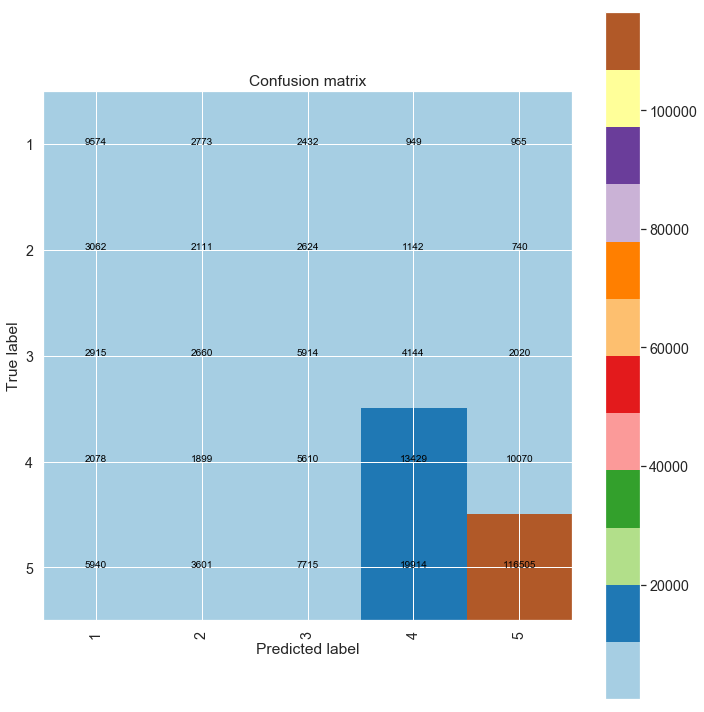

In [58]:
labels = clf.classes_
pred_test = clf.predict(vectorised_test_documents)
print(classification_report(y_test,pred_test,labels = labels))

cnf_matrix = confusion_matrix(y_test, pred_test)
print(plot_confusion_matrix(cnf_matrix, classes = labels))

Обучить рекуррентную нейронную сеть для предсказания оценки пользователя по его отзыву. Использовать случайную инициализация весов.

- add stopwords?

In [33]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, random_state = seed, test_size=0.3, shuffle=True)

In [16]:
#convert words to sequence
from keras.preprocessing.text import Tokenizer

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.datasets import imdb


In [17]:
%%time
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(x_train)

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

Wall time: 1min 33s


In [18]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_y_train = encoder.transform(y_train)
encoded_y_test = encoder.transform(y_test)
# convert integers to dummy variables (i.e. one hot encoded)
y_train = np_utils.to_categorical(encoded_y_train)
y_test = np_utils.to_categorical(encoded_y_test)

In [19]:
#y_train = np.array(y_train)
#y_test = np.array(y_test)

In [20]:


print (vocab_size)

print(x_train[0])

print(len(x_train[0]))

print(len(x_train))

485477
[851, 7, 12, 7, 3059, 3303, 4643, 618, 7, 44, 1, 12, 202, 257, 207, 2474, 466, 4, 4996, 1332, 1807, 51, 1203, 92, 1258, 3, 2526, 504, 1, 3278, 2034, 11, 2968, 629, 1336, 581, 52, 3, 546, 1109, 2282, 308, 108, 23, 2842, 144, 1202, 11, 925, 2968, 898, 52, 2431, 1758, 33, 3394, 546, 1109, 1686, 2, 4355, 1, 2, 3, 33, 3, 4441, 1075, 1, 365, 7, 1, 2034, 15, 2724, 11, 28, 20, 3633, 39, 1, 548, 13, 80, 4, 3817, 11, 1967, 1093, 3690, 19, 6, 2560, 1, 2, 1696, 828, 1, 39, 5, 9, 4132, 4398, 3, 7, 3059, 1786, 7, 3059, 2, 4, 3784, 102, 3817, 665, 1525, 3729, 6, 33, 14, 1708, 7, 3059, 879, 4643, 7, 2726, 10, 54, 15, 283, 558, 3611]
133
538475


In [21]:
from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)

In [22]:
print(x_train[0])

[  23 2842  144 1202   11  925 2968  898   52 2431 1758   33 3394  546 1109
 1686    2 4355    1    2    3   33    3 4441 1075    1  365    7    1 2034
   15 2724   11   28   20 3633   39    1  548   13   80    4 3817   11 1967
 1093 3690   19    6 2560    1    2 1696  828    1   39    5    9 4132 4398
    3    7 3059 1786    7 3059    2    4 3784  102 3817  665 1525 3729    6
   33   14 1708    7 3059  879 4643    7 2726   10   54   15  283  558 3611]


In [ ]:
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
maxlen = 90
batch_size = 32
max_features = 20000

'''
vocab_size
embedding_dim = 50
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))''';

In [24]:
max_features * 128

2560000

In [27]:
model = Sequential()
model.add(Embedding(input_dim = vocab_size, output_dim= 128, input_length=maxlen))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax')) #softmax due to multiclass

# try using different optimizers and different optimizer configs
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 90, 128)           62141056  
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               98816     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 645       
Total params: 62,240,517
Trainable params: 62,240,517
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=2,
          validation_data=[x_test, y_test])

Train...
Train on 538475 samples, validate on 230776 samples
Epoch 1/2


  6400/538475 [..............................] - ETA: 11:18:40 - loss: 1.6174 - acc: 0.156 - ETA: 6:01:59 - loss: 1.6092 - acc: 0.250 - ETA: 4:16:08 - loss: 1.5937 - acc: 0.38 - ETA: 3:22:49 - loss: 1.5789 - acc: 0.46 - ETA: 2:51:08 - loss: 1.5676 - acc: 0.50 - ETA: 2:29:44 - loss: 1.5461 - acc: 0.54 - ETA: 2:14:33 - loss: 1.5257 - acc: 0.57 - ETA: 2:03:17 - loss: 1.5083 - acc: 0.58 - ETA: 1:54:42 - loss: 1.4888 - acc: 0.60 - ETA: 1:47:46 - loss: 1.4685 - acc: 0.62 - ETA: 1:42:11 - loss: 1.4589 - acc: 0.61 - ETA: 1:37:20 - loss: 1.4345 - acc: 0.62 - ETA: 1:33:11 - loss: 1.4223 - acc: 0.62 - ETA: 1:29:36 - loss: 1.3909 - acc: 0.62 - ETA: 1:26:52 - loss: 1.3617 - acc: 0.63 - ETA: 1:24:14 - loss: 1.3418 - acc: 0.64 - ETA: 1:21:56 - loss: 1.3403 - acc: 0.63 - ETA: 1:19:48 - loss: 1.3319 - acc: 0.64 - ETA: 1:18:01 - loss: 1.3320 - acc: 0.64 - ETA: 1:16:16 - loss: 1.3100 - acc: 0.65 - ETA: 1:14:51 - loss: 1.3073 - acc: 0.65 - ETA: 1:13:31 - loss: 1.2892 - acc: 0.65 - ETA: 1:12:20 - loss: 1.2

 12928/538475 [..............................] - ETA: 48:20 - loss: 1.0606 - acc: 0.66 - ETA: 48:20 - loss: 1.0607 - acc: 0.66 - ETA: 48:24 - loss: 1.0591 - acc: 0.66 - ETA: 48:22 - loss: 1.0590 - acc: 0.66 - ETA: 48:21 - loss: 1.0569 - acc: 0.66 - ETA: 48:19 - loss: 1.0561 - acc: 0.66 - ETA: 48:18 - loss: 1.0554 - acc: 0.66 - ETA: 48:21 - loss: 1.0564 - acc: 0.66 - ETA: 48:21 - loss: 1.0557 - acc: 0.66 - ETA: 48:20 - loss: 1.0555 - acc: 0.66 - ETA: 48:20 - loss: 1.0561 - acc: 0.66 - ETA: 48:18 - loss: 1.0577 - acc: 0.66 - ETA: 48:16 - loss: 1.0569 - acc: 0.66 - ETA: 48:15 - loss: 1.0563 - acc: 0.66 - ETA: 48:13 - loss: 1.0573 - acc: 0.66 - ETA: 48:12 - loss: 1.0564 - acc: 0.66 - ETA: 48:11 - loss: 1.0561 - acc: 0.66 - ETA: 48:12 - loss: 1.0559 - acc: 0.66 - ETA: 48:12 - loss: 1.0558 - acc: 0.66 - ETA: 48:10 - loss: 1.0557 - acc: 0.66 - ETA: 48:13 - loss: 1.0536 - acc: 0.66 - ETA: 48:13 - loss: 1.0519 - acc: 0.66 - ETA: 48:13 - loss: 1.0525 - acc: 0.66 - ETA: 48:14 - loss: 1.0515 - acc

 19456/538475 [>.............................] - ETA: 47:32 - loss: 1.0090 - acc: 0.66 - ETA: 47:32 - loss: 1.0083 - acc: 0.66 - ETA: 47:31 - loss: 1.0082 - acc: 0.66 - ETA: 47:31 - loss: 1.0078 - acc: 0.66 - ETA: 47:32 - loss: 1.0079 - acc: 0.66 - ETA: 47:34 - loss: 1.0073 - acc: 0.66 - ETA: 47:33 - loss: 1.0065 - acc: 0.66 - ETA: 47:32 - loss: 1.0056 - acc: 0.66 - ETA: 47:32 - loss: 1.0050 - acc: 0.66 - ETA: 47:31 - loss: 1.0046 - acc: 0.66 - ETA: 47:30 - loss: 1.0047 - acc: 0.66 - ETA: 47:29 - loss: 1.0040 - acc: 0.66 - ETA: 47:29 - loss: 1.0038 - acc: 0.66 - ETA: 47:28 - loss: 1.0037 - acc: 0.66 - ETA: 47:27 - loss: 1.0038 - acc: 0.66 - ETA: 47:27 - loss: 1.0030 - acc: 0.66 - ETA: 47:26 - loss: 1.0026 - acc: 0.66 - ETA: 47:25 - loss: 1.0022 - acc: 0.66 - ETA: 47:24 - loss: 1.0017 - acc: 0.66 - ETA: 47:23 - loss: 1.0018 - acc: 0.66 - ETA: 47:23 - loss: 1.0019 - acc: 0.66 - ETA: 47:22 - loss: 1.0025 - acc: 0.66 - ETA: 47:21 - loss: 1.0028 - acc: 0.66 - ETA: 47:20 - loss: 1.0029 - acc

 25984/538475 [>.............................] - ETA: 46:07 - loss: 0.9754 - acc: 0.66 - ETA: 46:07 - loss: 0.9755 - acc: 0.66 - ETA: 46:06 - loss: 0.9755 - acc: 0.66 - ETA: 46:05 - loss: 0.9757 - acc: 0.66 - ETA: 46:05 - loss: 0.9753 - acc: 0.66 - ETA: 46:04 - loss: 0.9746 - acc: 0.66 - ETA: 46:04 - loss: 0.9748 - acc: 0.66 - ETA: 46:03 - loss: 0.9754 - acc: 0.66 - ETA: 46:03 - loss: 0.9755 - acc: 0.66 - ETA: 46:02 - loss: 0.9755 - acc: 0.66 - ETA: 46:02 - loss: 0.9754 - acc: 0.66 - ETA: 46:03 - loss: 0.9755 - acc: 0.66 - ETA: 46:02 - loss: 0.9753 - acc: 0.66 - ETA: 46:02 - loss: 0.9750 - acc: 0.66 - ETA: 46:03 - loss: 0.9748 - acc: 0.66 - ETA: 46:02 - loss: 0.9745 - acc: 0.66 - ETA: 46:02 - loss: 0.9739 - acc: 0.66 - ETA: 46:03 - loss: 0.9737 - acc: 0.66 - ETA: 46:02 - loss: 0.9735 - acc: 0.66 - ETA: 46:03 - loss: 0.9730 - acc: 0.66 - ETA: 46:03 - loss: 0.9733 - acc: 0.66 - ETA: 46:02 - loss: 0.9732 - acc: 0.66 - ETA: 46:02 - loss: 0.9727 - acc: 0.66 - ETA: 46:01 - loss: 0.9728 - acc

 32512/538475 [>.............................] - ETA: 45:32 - loss: 0.9538 - acc: 0.66 - ETA: 45:32 - loss: 0.9538 - acc: 0.66 - ETA: 45:32 - loss: 0.9535 - acc: 0.66 - ETA: 45:33 - loss: 0.9537 - acc: 0.66 - ETA: 45:33 - loss: 0.9534 - acc: 0.66 - ETA: 45:33 - loss: 0.9531 - acc: 0.66 - ETA: 45:32 - loss: 0.9531 - acc: 0.66 - ETA: 45:33 - loss: 0.9530 - acc: 0.66 - ETA: 45:32 - loss: 0.9529 - acc: 0.66 - ETA: 45:32 - loss: 0.9526 - acc: 0.66 - ETA: 45:32 - loss: 0.9527 - acc: 0.66 - ETA: 45:31 - loss: 0.9529 - acc: 0.66 - ETA: 45:31 - loss: 0.9531 - acc: 0.66 - ETA: 45:30 - loss: 0.9528 - acc: 0.66 - ETA: 45:30 - loss: 0.9527 - acc: 0.66 - ETA: 45:29 - loss: 0.9524 - acc: 0.66 - ETA: 45:29 - loss: 0.9525 - acc: 0.66 - ETA: 45:29 - loss: 0.9522 - acc: 0.66 - ETA: 45:28 - loss: 0.9522 - acc: 0.66 - ETA: 45:28 - loss: 0.9522 - acc: 0.66 - ETA: 45:27 - loss: 0.9520 - acc: 0.66 - ETA: 45:27 - loss: 0.9518 - acc: 0.66 - ETA: 45:27 - loss: 0.9514 - acc: 0.66 - ETA: 45:27 - loss: 0.9512 - acc

 39040/538475 [=>............................] - ETA: 44:54 - loss: 0.9348 - acc: 0.67 - ETA: 44:54 - loss: 0.9348 - acc: 0.67 - ETA: 44:53 - loss: 0.9348 - acc: 0.67 - ETA: 44:53 - loss: 0.9348 - acc: 0.67 - ETA: 44:52 - loss: 0.9349 - acc: 0.67 - ETA: 44:52 - loss: 0.9351 - acc: 0.67 - ETA: 44:51 - loss: 0.9350 - acc: 0.67 - ETA: 44:51 - loss: 0.9350 - acc: 0.67 - ETA: 44:50 - loss: 0.9349 - acc: 0.67 - ETA: 44:50 - loss: 0.9349 - acc: 0.67 - ETA: 44:49 - loss: 0.9348 - acc: 0.67 - ETA: 44:49 - loss: 0.9349 - acc: 0.67 - ETA: 44:48 - loss: 0.9348 - acc: 0.67 - ETA: 44:48 - loss: 0.9349 - acc: 0.67 - ETA: 44:48 - loss: 0.9347 - acc: 0.67 - ETA: 44:48 - loss: 0.9346 - acc: 0.67 - ETA: 44:48 - loss: 0.9343 - acc: 0.67 - ETA: 44:48 - loss: 0.9341 - acc: 0.67 - ETA: 44:48 - loss: 0.9338 - acc: 0.67 - ETA: 44:48 - loss: 0.9337 - acc: 0.67 - ETA: 44:47 - loss: 0.9336 - acc: 0.67 - ETA: 44:47 - loss: 0.9337 - acc: 0.67 - ETA: 44:47 - loss: 0.9337 - acc: 0.67 - ETA: 44:47 - loss: 0.9335 - acc

 45568/538475 [=>............................] - ETA: 44:28 - loss: 0.9217 - acc: 0.67 - ETA: 44:27 - loss: 0.9216 - acc: 0.67 - ETA: 44:27 - loss: 0.9214 - acc: 0.67 - ETA: 44:26 - loss: 0.9213 - acc: 0.67 - ETA: 44:26 - loss: 0.9214 - acc: 0.67 - ETA: 44:25 - loss: 0.9212 - acc: 0.67 - ETA: 44:25 - loss: 0.9212 - acc: 0.67 - ETA: 44:24 - loss: 0.9211 - acc: 0.67 - ETA: 44:24 - loss: 0.9209 - acc: 0.67 - ETA: 44:23 - loss: 0.9210 - acc: 0.67 - ETA: 44:23 - loss: 0.9208 - acc: 0.67 - ETA: 44:22 - loss: 0.9209 - acc: 0.67 - ETA: 44:21 - loss: 0.9207 - acc: 0.67 - ETA: 44:21 - loss: 0.9207 - acc: 0.67 - ETA: 44:20 - loss: 0.9208 - acc: 0.67 - ETA: 44:20 - loss: 0.9210 - acc: 0.67 - ETA: 44:20 - loss: 0.9212 - acc: 0.67 - ETA: 44:19 - loss: 0.9211 - acc: 0.67 - ETA: 44:19 - loss: 0.9210 - acc: 0.67 - ETA: 44:18 - loss: 0.9208 - acc: 0.67 - ETA: 44:18 - loss: 0.9208 - acc: 0.67 - ETA: 44:17 - loss: 0.9206 - acc: 0.67 - ETA: 44:17 - loss: 0.9208 - acc: 0.67 - ETA: 44:16 - loss: 0.9208 - acc

 52096/538475 [=>............................] - ETA: 43:09 - loss: 0.9112 - acc: 0.67 - ETA: 43:08 - loss: 0.9112 - acc: 0.67 - ETA: 43:08 - loss: 0.9112 - acc: 0.67 - ETA: 43:08 - loss: 0.9112 - acc: 0.67 - ETA: 43:08 - loss: 0.9110 - acc: 0.67 - ETA: 43:07 - loss: 0.9108 - acc: 0.67 - ETA: 43:07 - loss: 0.9107 - acc: 0.67 - ETA: 43:07 - loss: 0.9105 - acc: 0.67 - ETA: 43:06 - loss: 0.9104 - acc: 0.67 - ETA: 43:06 - loss: 0.9104 - acc: 0.67 - ETA: 43:05 - loss: 0.9104 - acc: 0.67 - ETA: 43:05 - loss: 0.9103 - acc: 0.67 - ETA: 43:05 - loss: 0.9101 - acc: 0.67 - ETA: 43:05 - loss: 0.9102 - acc: 0.67 - ETA: 43:04 - loss: 0.9103 - acc: 0.67 - ETA: 43:04 - loss: 0.9101 - acc: 0.67 - ETA: 43:04 - loss: 0.9101 - acc: 0.67 - ETA: 43:03 - loss: 0.9100 - acc: 0.67 - ETA: 43:03 - loss: 0.9099 - acc: 0.67 - ETA: 43:03 - loss: 0.9100 - acc: 0.67 - ETA: 43:02 - loss: 0.9098 - acc: 0.67 - ETA: 43:02 - loss: 0.9097 - acc: 0.67 - ETA: 43:02 - loss: 0.9095 - acc: 0.67 - ETA: 43:01 - loss: 0.9093 - acc

 58624/538475 [==>...........................] - ETA: 42:08 - loss: 0.9001 - acc: 0.67 - ETA: 42:08 - loss: 0.9000 - acc: 0.67 - ETA: 42:08 - loss: 0.9000 - acc: 0.67 - ETA: 42:07 - loss: 0.9000 - acc: 0.67 - ETA: 42:07 - loss: 0.8998 - acc: 0.67 - ETA: 42:06 - loss: 0.8998 - acc: 0.67 - ETA: 42:06 - loss: 0.8997 - acc: 0.67 - ETA: 42:06 - loss: 0.8996 - acc: 0.67 - ETA: 42:06 - loss: 0.8998 - acc: 0.67 - ETA: 42:06 - loss: 0.8997 - acc: 0.67 - ETA: 42:05 - loss: 0.8998 - acc: 0.67 - ETA: 42:05 - loss: 0.8998 - acc: 0.67 - ETA: 42:05 - loss: 0.8998 - acc: 0.67 - ETA: 42:04 - loss: 0.8998 - acc: 0.67 - ETA: 42:04 - loss: 0.8996 - acc: 0.67 - ETA: 42:04 - loss: 0.8997 - acc: 0.67 - ETA: 42:03 - loss: 0.8995 - acc: 0.67 - ETA: 42:03 - loss: 0.8994 - acc: 0.67 - ETA: 42:03 - loss: 0.8993 - acc: 0.67 - ETA: 42:02 - loss: 0.8991 - acc: 0.67 - ETA: 42:02 - loss: 0.8992 - acc: 0.67 - ETA: 42:02 - loss: 0.8991 - acc: 0.67 - ETA: 42:02 - loss: 0.8991 - acc: 0.67 - ETA: 42:01 - loss: 0.8990 - acc

 65152/538475 [==>...........................] - ETA: 41:15 - loss: 0.8907 - acc: 0.68 - ETA: 41:15 - loss: 0.8907 - acc: 0.68 - ETA: 41:14 - loss: 0.8908 - acc: 0.68 - ETA: 41:14 - loss: 0.8906 - acc: 0.68 - ETA: 41:14 - loss: 0.8906 - acc: 0.68 - ETA: 41:14 - loss: 0.8905 - acc: 0.68 - ETA: 41:13 - loss: 0.8904 - acc: 0.68 - ETA: 41:13 - loss: 0.8904 - acc: 0.68 - ETA: 41:13 - loss: 0.8904 - acc: 0.68 - ETA: 41:13 - loss: 0.8902 - acc: 0.68 - ETA: 41:13 - loss: 0.8901 - acc: 0.68 - ETA: 41:12 - loss: 0.8900 - acc: 0.68 - ETA: 41:12 - loss: 0.8900 - acc: 0.68 - ETA: 41:12 - loss: 0.8899 - acc: 0.68 - ETA: 41:11 - loss: 0.8898 - acc: 0.68 - ETA: 41:11 - loss: 0.8898 - acc: 0.68 - ETA: 41:11 - loss: 0.8897 - acc: 0.68 - ETA: 41:10 - loss: 0.8896 - acc: 0.68 - ETA: 41:10 - loss: 0.8894 - acc: 0.68 - ETA: 41:10 - loss: 0.8893 - acc: 0.68 - ETA: 41:10 - loss: 0.8893 - acc: 0.68 - ETA: 41:09 - loss: 0.8893 - acc: 0.68 - ETA: 41:09 - loss: 0.8892 - acc: 0.68 - ETA: 41:09 - loss: 0.8891 - acc

 71680/538475 [==>...........................] - ETA: 40:18 - loss: 0.8842 - acc: 0.68 - ETA: 40:18 - loss: 0.8843 - acc: 0.68 - ETA: 40:18 - loss: 0.8841 - acc: 0.68 - ETA: 40:17 - loss: 0.8840 - acc: 0.68 - ETA: 40:17 - loss: 0.8839 - acc: 0.68 - ETA: 40:17 - loss: 0.8838 - acc: 0.68 - ETA: 40:16 - loss: 0.8838 - acc: 0.68 - ETA: 40:16 - loss: 0.8837 - acc: 0.68 - ETA: 40:15 - loss: 0.8836 - acc: 0.68 - ETA: 40:15 - loss: 0.8837 - acc: 0.68 - ETA: 40:15 - loss: 0.8835 - acc: 0.68 - ETA: 40:14 - loss: 0.8834 - acc: 0.68 - ETA: 40:14 - loss: 0.8834 - acc: 0.68 - ETA: 40:14 - loss: 0.8833 - acc: 0.68 - ETA: 40:13 - loss: 0.8832 - acc: 0.68 - ETA: 40:13 - loss: 0.8831 - acc: 0.68 - ETA: 40:13 - loss: 0.8831 - acc: 0.68 - ETA: 40:12 - loss: 0.8832 - acc: 0.68 - ETA: 40:12 - loss: 0.8832 - acc: 0.68 - ETA: 40:11 - loss: 0.8833 - acc: 0.68 - ETA: 40:11 - loss: 0.8833 - acc: 0.68 - ETA: 40:11 - loss: 0.8833 - acc: 0.68 - ETA: 40:10 - loss: 0.8833 - acc: 0.68 - ETA: 40:10 - loss: 0.8832 - acc

 78208/538475 [===>..........................] - ETA: 39:09 - loss: 0.8784 - acc: 0.68 - ETA: 39:08 - loss: 0.8785 - acc: 0.68 - ETA: 39:08 - loss: 0.8784 - acc: 0.68 - ETA: 39:08 - loss: 0.8782 - acc: 0.68 - ETA: 39:07 - loss: 0.8781 - acc: 0.68 - ETA: 39:07 - loss: 0.8782 - acc: 0.68 - ETA: 39:07 - loss: 0.8782 - acc: 0.68 - ETA: 39:06 - loss: 0.8783 - acc: 0.68 - ETA: 39:06 - loss: 0.8784 - acc: 0.68 - ETA: 39:06 - loss: 0.8784 - acc: 0.68 - ETA: 39:05 - loss: 0.8783 - acc: 0.68 - ETA: 39:05 - loss: 0.8781 - acc: 0.68 - ETA: 39:05 - loss: 0.8781 - acc: 0.68 - ETA: 39:04 - loss: 0.8780 - acc: 0.68 - ETA: 39:04 - loss: 0.8779 - acc: 0.68 - ETA: 39:04 - loss: 0.8779 - acc: 0.68 - ETA: 39:03 - loss: 0.8778 - acc: 0.68 - ETA: 39:03 - loss: 0.8779 - acc: 0.68 - ETA: 39:03 - loss: 0.8779 - acc: 0.68 - ETA: 39:02 - loss: 0.8778 - acc: 0.68 - ETA: 39:02 - loss: 0.8778 - acc: 0.68 - ETA: 39:02 - loss: 0.8778 - acc: 0.68 - ETA: 39:01 - loss: 0.8777 - acc: 0.68 - ETA: 39:01 - loss: 0.8777 - acc

 84736/538475 [===>..........................] - ETA: 38:13 - loss: 0.8722 - acc: 0.68 - ETA: 38:13 - loss: 0.8721 - acc: 0.68 - ETA: 38:13 - loss: 0.8720 - acc: 0.68 - ETA: 38:12 - loss: 0.8719 - acc: 0.68 - ETA: 38:12 - loss: 0.8720 - acc: 0.68 - ETA: 38:12 - loss: 0.8720 - acc: 0.68 - ETA: 38:11 - loss: 0.8719 - acc: 0.68 - ETA: 38:11 - loss: 0.8719 - acc: 0.68 - ETA: 38:11 - loss: 0.8718 - acc: 0.68 - ETA: 38:11 - loss: 0.8717 - acc: 0.68 - ETA: 38:10 - loss: 0.8717 - acc: 0.68 - ETA: 38:10 - loss: 0.8716 - acc: 0.68 - ETA: 38:10 - loss: 0.8715 - acc: 0.68 - ETA: 38:09 - loss: 0.8716 - acc: 0.68 - ETA: 38:09 - loss: 0.8716 - acc: 0.68 - ETA: 38:09 - loss: 0.8715 - acc: 0.68 - ETA: 38:08 - loss: 0.8714 - acc: 0.68 - ETA: 38:08 - loss: 0.8715 - acc: 0.68 - ETA: 38:08 - loss: 0.8714 - acc: 0.68 - ETA: 38:07 - loss: 0.8714 - acc: 0.68 - ETA: 38:07 - loss: 0.8713 - acc: 0.68 - ETA: 38:07 - loss: 0.8712 - acc: 0.68 - ETA: 38:07 - loss: 0.8711 - acc: 0.68 - ETA: 38:06 - loss: 0.8711 - acc

 91264/538475 [====>.........................] - ETA: 37:30 - loss: 0.8680 - acc: 0.68 - ETA: 37:30 - loss: 0.8681 - acc: 0.68 - ETA: 37:30 - loss: 0.8681 - acc: 0.68 - ETA: 37:29 - loss: 0.8681 - acc: 0.68 - ETA: 37:29 - loss: 0.8680 - acc: 0.68 - ETA: 37:29 - loss: 0.8681 - acc: 0.68 - ETA: 37:29 - loss: 0.8680 - acc: 0.68 - ETA: 37:28 - loss: 0.8680 - acc: 0.68 - ETA: 37:28 - loss: 0.8679 - acc: 0.68 - ETA: 37:28 - loss: 0.8679 - acc: 0.68 - ETA: 37:28 - loss: 0.8679 - acc: 0.68 - ETA: 37:27 - loss: 0.8679 - acc: 0.68 - ETA: 37:27 - loss: 0.8677 - acc: 0.68 - ETA: 37:27 - loss: 0.8677 - acc: 0.68 - ETA: 37:27 - loss: 0.8676 - acc: 0.68 - ETA: 37:26 - loss: 0.8677 - acc: 0.68 - ETA: 37:26 - loss: 0.8677 - acc: 0.68 - ETA: 37:26 - loss: 0.8677 - acc: 0.68 - ETA: 37:26 - loss: 0.8676 - acc: 0.68 - ETA: 37:25 - loss: 0.8676 - acc: 0.68 - ETA: 37:25 - loss: 0.8676 - acc: 0.68 - ETA: 37:25 - loss: 0.8676 - acc: 0.68 - ETA: 37:25 - loss: 0.8676 - acc: 0.68 - ETA: 37:24 - loss: 0.8675 - acc

 97792/538475 [====>.........................] - ETA: 36:50 - loss: 0.8644 - acc: 0.68 - ETA: 36:50 - loss: 0.8644 - acc: 0.68 - ETA: 36:49 - loss: 0.8643 - acc: 0.68 - ETA: 36:49 - loss: 0.8644 - acc: 0.68 - ETA: 36:49 - loss: 0.8645 - acc: 0.68 - ETA: 36:49 - loss: 0.8645 - acc: 0.68 - ETA: 36:49 - loss: 0.8645 - acc: 0.68 - ETA: 36:48 - loss: 0.8645 - acc: 0.68 - ETA: 36:48 - loss: 0.8645 - acc: 0.68 - ETA: 36:48 - loss: 0.8645 - acc: 0.68 - ETA: 36:48 - loss: 0.8644 - acc: 0.68 - ETA: 36:47 - loss: 0.8644 - acc: 0.68 - ETA: 36:47 - loss: 0.8643 - acc: 0.68 - ETA: 36:47 - loss: 0.8642 - acc: 0.68 - ETA: 36:47 - loss: 0.8642 - acc: 0.68 - ETA: 36:46 - loss: 0.8641 - acc: 0.68 - ETA: 36:46 - loss: 0.8642 - acc: 0.68 - ETA: 36:46 - loss: 0.8642 - acc: 0.68 - ETA: 36:46 - loss: 0.8642 - acc: 0.68 - ETA: 36:46 - loss: 0.8642 - acc: 0.68 - ETA: 36:45 - loss: 0.8642 - acc: 0.68 - ETA: 36:45 - loss: 0.8640 - acc: 0.68 - ETA: 36:45 - loss: 0.8640 - acc: 0.68 - ETA: 36:45 - loss: 0.8639 - acc

104320/538475 [====>.........................] - ETA: 36:15 - loss: 0.8610 - acc: 0.68 - ETA: 36:15 - loss: 0.8609 - acc: 0.68 - ETA: 36:14 - loss: 0.8608 - acc: 0.68 - ETA: 36:14 - loss: 0.8608 - acc: 0.68 - ETA: 36:14 - loss: 0.8607 - acc: 0.68 - ETA: 36:14 - loss: 0.8608 - acc: 0.68 - ETA: 36:14 - loss: 0.8607 - acc: 0.68 - ETA: 36:14 - loss: 0.8607 - acc: 0.68 - ETA: 36:14 - loss: 0.8607 - acc: 0.68 - ETA: 36:13 - loss: 0.8607 - acc: 0.68 - ETA: 36:13 - loss: 0.8607 - acc: 0.68 - ETA: 36:13 - loss: 0.8606 - acc: 0.68 - ETA: 36:13 - loss: 0.8606 - acc: 0.68 - ETA: 36:13 - loss: 0.8605 - acc: 0.68 - ETA: 36:13 - loss: 0.8604 - acc: 0.68 - ETA: 36:13 - loss: 0.8605 - acc: 0.68 - ETA: 36:13 - loss: 0.8604 - acc: 0.68 - ETA: 36:13 - loss: 0.8604 - acc: 0.68 - ETA: 36:12 - loss: 0.8604 - acc: 0.68 - ETA: 36:12 - loss: 0.8604 - acc: 0.68 - ETA: 36:12 - loss: 0.8603 - acc: 0.68 - ETA: 36:12 - loss: 0.8604 - acc: 0.68 - ETA: 36:12 - loss: 0.8603 - acc: 0.68 - ETA: 36:12 - loss: 0.8604 - acc

110848/538475 [=====>........................] - ETA: 35:56 - loss: 0.8564 - acc: 0.68 - ETA: 35:56 - loss: 0.8563 - acc: 0.68 - ETA: 35:55 - loss: 0.8563 - acc: 0.68 - ETA: 35:55 - loss: 0.8563 - acc: 0.68 - ETA: 35:55 - loss: 0.8564 - acc: 0.68 - ETA: 35:55 - loss: 0.8564 - acc: 0.68 - ETA: 35:55 - loss: 0.8564 - acc: 0.68 - ETA: 35:55 - loss: 0.8564 - acc: 0.68 - ETA: 35:55 - loss: 0.8564 - acc: 0.68 - ETA: 35:55 - loss: 0.8563 - acc: 0.68 - ETA: 35:55 - loss: 0.8563 - acc: 0.68 - ETA: 35:54 - loss: 0.8564 - acc: 0.68 - ETA: 35:54 - loss: 0.8563 - acc: 0.68 - ETA: 35:54 - loss: 0.8563 - acc: 0.68 - ETA: 35:54 - loss: 0.8563 - acc: 0.68 - ETA: 35:54 - loss: 0.8562 - acc: 0.68 - ETA: 35:54 - loss: 0.8563 - acc: 0.68 - ETA: 35:54 - loss: 0.8562 - acc: 0.68 - ETA: 35:54 - loss: 0.8561 - acc: 0.68 - ETA: 35:55 - loss: 0.8561 - acc: 0.68 - ETA: 35:55 - loss: 0.8561 - acc: 0.68 - ETA: 35:55 - loss: 0.8560 - acc: 0.68 - ETA: 35:55 - loss: 0.8560 - acc: 0.68 - ETA: 35:55 - loss: 0.8559 - acc

117376/538475 [=====>........................] - ETA: 35:15 - loss: 0.8519 - acc: 0.69 - ETA: 35:14 - loss: 0.8519 - acc: 0.69 - ETA: 35:14 - loss: 0.8518 - acc: 0.69 - ETA: 35:14 - loss: 0.8518 - acc: 0.69 - ETA: 35:14 - loss: 0.8518 - acc: 0.69 - ETA: 35:13 - loss: 0.8517 - acc: 0.69 - ETA: 35:13 - loss: 0.8518 - acc: 0.69 - ETA: 35:13 - loss: 0.8517 - acc: 0.69 - ETA: 35:13 - loss: 0.8517 - acc: 0.69 - ETA: 35:12 - loss: 0.8517 - acc: 0.69 - ETA: 35:12 - loss: 0.8517 - acc: 0.69 - ETA: 35:12 - loss: 0.8517 - acc: 0.69 - ETA: 35:12 - loss: 0.8517 - acc: 0.69 - ETA: 35:11 - loss: 0.8517 - acc: 0.69 - ETA: 35:11 - loss: 0.8517 - acc: 0.69 - ETA: 35:11 - loss: 0.8517 - acc: 0.69 - ETA: 35:11 - loss: 0.8517 - acc: 0.69 - ETA: 35:11 - loss: 0.8516 - acc: 0.69 - ETA: 35:10 - loss: 0.8515 - acc: 0.69 - ETA: 35:10 - loss: 0.8515 - acc: 0.69 - ETA: 35:10 - loss: 0.8515 - acc: 0.69 - ETA: 35:10 - loss: 0.8515 - acc: 0.69 - ETA: 35:09 - loss: 0.8515 - acc: 0.69 - ETA: 35:09 - loss: 0.8516 - acc

123904/538475 [=====>........................] - ETA: 34:37 - loss: 0.8474 - acc: 0.69 - ETA: 34:36 - loss: 0.8474 - acc: 0.69 - ETA: 34:36 - loss: 0.8474 - acc: 0.69 - ETA: 34:36 - loss: 0.8473 - acc: 0.69 - ETA: 34:36 - loss: 0.8473 - acc: 0.69 - ETA: 34:36 - loss: 0.8473 - acc: 0.69 - ETA: 34:35 - loss: 0.8473 - acc: 0.69 - ETA: 34:35 - loss: 0.8473 - acc: 0.69 - ETA: 34:35 - loss: 0.8473 - acc: 0.69 - ETA: 34:35 - loss: 0.8473 - acc: 0.69 - ETA: 34:34 - loss: 0.8472 - acc: 0.69 - ETA: 34:34 - loss: 0.8472 - acc: 0.69 - ETA: 34:34 - loss: 0.8471 - acc: 0.69 - ETA: 34:34 - loss: 0.8472 - acc: 0.69 - ETA: 34:33 - loss: 0.8472 - acc: 0.69 - ETA: 34:33 - loss: 0.8472 - acc: 0.69 - ETA: 34:33 - loss: 0.8472 - acc: 0.69 - ETA: 34:33 - loss: 0.8471 - acc: 0.69 - ETA: 34:32 - loss: 0.8472 - acc: 0.69 - ETA: 34:32 - loss: 0.8472 - acc: 0.69 - ETA: 34:32 - loss: 0.8472 - acc: 0.69 - ETA: 34:32 - loss: 0.8472 - acc: 0.69 - ETA: 34:31 - loss: 0.8470 - acc: 0.69 - ETA: 34:31 - loss: 0.8470 - acc

130432/538475 [======>.......................] - ETA: 33:51 - loss: 0.8443 - acc: 0.69 - ETA: 33:51 - loss: 0.8443 - acc: 0.69 - ETA: 33:51 - loss: 0.8442 - acc: 0.69 - ETA: 33:51 - loss: 0.8442 - acc: 0.69 - ETA: 33:50 - loss: 0.8441 - acc: 0.69 - ETA: 33:50 - loss: 0.8441 - acc: 0.69 - ETA: 33:50 - loss: 0.8440 - acc: 0.69 - ETA: 33:50 - loss: 0.8440 - acc: 0.69 - ETA: 33:50 - loss: 0.8440 - acc: 0.69 - ETA: 33:50 - loss: 0.8439 - acc: 0.69 - ETA: 33:50 - loss: 0.8439 - acc: 0.69 - ETA: 33:50 - loss: 0.8439 - acc: 0.69 - ETA: 33:49 - loss: 0.8440 - acc: 0.69 - ETA: 33:49 - loss: 0.8440 - acc: 0.69 - ETA: 33:49 - loss: 0.8440 - acc: 0.69 - ETA: 33:49 - loss: 0.8440 - acc: 0.69 - ETA: 33:49 - loss: 0.8440 - acc: 0.69 - ETA: 33:48 - loss: 0.8439 - acc: 0.69 - ETA: 33:48 - loss: 0.8438 - acc: 0.69 - ETA: 33:48 - loss: 0.8439 - acc: 0.69 - ETA: 33:48 - loss: 0.8438 - acc: 0.69 - ETA: 33:48 - loss: 0.8439 - acc: 0.69 - ETA: 33:48 - loss: 0.8438 - acc: 0.69 - ETA: 33:47 - loss: 0.8438 - acc

136960/538475 [======>.......................] - ETA: 33:18 - loss: 0.8408 - acc: 0.69 - ETA: 33:18 - loss: 0.8408 - acc: 0.69 - ETA: 33:18 - loss: 0.8408 - acc: 0.69 - ETA: 33:18 - loss: 0.8408 - acc: 0.69 - ETA: 33:18 - loss: 0.8408 - acc: 0.69 - ETA: 33:17 - loss: 0.8408 - acc: 0.69 - ETA: 33:17 - loss: 0.8408 - acc: 0.69 - ETA: 33:17 - loss: 0.8408 - acc: 0.69 - ETA: 33:17 - loss: 0.8409 - acc: 0.69 - ETA: 33:17 - loss: 0.8409 - acc: 0.69 - ETA: 33:17 - loss: 0.8408 - acc: 0.69 - ETA: 33:16 - loss: 0.8408 - acc: 0.69 - ETA: 33:16 - loss: 0.8408 - acc: 0.69 - ETA: 33:16 - loss: 0.8407 - acc: 0.69 - ETA: 33:16 - loss: 0.8407 - acc: 0.69 - ETA: 33:16 - loss: 0.8407 - acc: 0.69 - ETA: 33:15 - loss: 0.8407 - acc: 0.69 - ETA: 33:15 - loss: 0.8407 - acc: 0.69 - ETA: 33:15 - loss: 0.8407 - acc: 0.69 - ETA: 33:15 - loss: 0.8406 - acc: 0.69 - ETA: 33:15 - loss: 0.8406 - acc: 0.69 - ETA: 33:15 - loss: 0.8406 - acc: 0.69 - ETA: 33:14 - loss: 0.8405 - acc: 0.69 - ETA: 33:14 - loss: 0.8405 - acc

143488/538475 [======>.......................] - ETA: 32:46 - loss: 0.8378 - acc: 0.69 - ETA: 32:46 - loss: 0.8377 - acc: 0.69 - ETA: 32:45 - loss: 0.8377 - acc: 0.69 - ETA: 32:45 - loss: 0.8377 - acc: 0.69 - ETA: 32:45 - loss: 0.8377 - acc: 0.69 - ETA: 32:45 - loss: 0.8377 - acc: 0.69 - ETA: 32:45 - loss: 0.8376 - acc: 0.69 - ETA: 32:44 - loss: 0.8376 - acc: 0.69 - ETA: 32:44 - loss: 0.8376 - acc: 0.69 - ETA: 32:44 - loss: 0.8375 - acc: 0.69 - ETA: 32:44 - loss: 0.8374 - acc: 0.69 - ETA: 32:44 - loss: 0.8375 - acc: 0.69 - ETA: 32:44 - loss: 0.8375 - acc: 0.69 - ETA: 32:43 - loss: 0.8375 - acc: 0.69 - ETA: 32:43 - loss: 0.8375 - acc: 0.69 - ETA: 32:43 - loss: 0.8375 - acc: 0.69 - ETA: 32:43 - loss: 0.8375 - acc: 0.69 - ETA: 32:43 - loss: 0.8375 - acc: 0.69 - ETA: 32:42 - loss: 0.8375 - acc: 0.69 - ETA: 32:42 - loss: 0.8375 - acc: 0.69 - ETA: 32:42 - loss: 0.8375 - acc: 0.69 - ETA: 32:42 - loss: 0.8374 - acc: 0.69 - ETA: 32:42 - loss: 0.8375 - acc: 0.69 - ETA: 32:41 - loss: 0.8374 - acc

150016/538475 [=======>......................] - ETA: 32:13 - loss: 0.8340 - acc: 0.69 - ETA: 32:13 - loss: 0.8340 - acc: 0.69 - ETA: 32:13 - loss: 0.8340 - acc: 0.69 - ETA: 32:12 - loss: 0.8340 - acc: 0.69 - ETA: 32:12 - loss: 0.8341 - acc: 0.69 - ETA: 32:12 - loss: 0.8340 - acc: 0.69 - ETA: 32:12 - loss: 0.8340 - acc: 0.69 - ETA: 32:12 - loss: 0.8340 - acc: 0.69 - ETA: 32:11 - loss: 0.8340 - acc: 0.69 - ETA: 32:11 - loss: 0.8339 - acc: 0.69 - ETA: 32:11 - loss: 0.8339 - acc: 0.69 - ETA: 32:11 - loss: 0.8338 - acc: 0.69 - ETA: 32:10 - loss: 0.8338 - acc: 0.69 - ETA: 32:10 - loss: 0.8338 - acc: 0.69 - ETA: 32:10 - loss: 0.8338 - acc: 0.69 - ETA: 32:10 - loss: 0.8338 - acc: 0.69 - ETA: 32:10 - loss: 0.8338 - acc: 0.69 - ETA: 32:09 - loss: 0.8338 - acc: 0.69 - ETA: 32:09 - loss: 0.8338 - acc: 0.69 - ETA: 32:09 - loss: 0.8338 - acc: 0.69 - ETA: 32:09 - loss: 0.8338 - acc: 0.69 - ETA: 32:09 - loss: 0.8338 - acc: 0.69 - ETA: 32:08 - loss: 0.8339 - acc: 0.69 - ETA: 32:08 - loss: 0.8339 - acc

156544/538475 [=======>......................] - ETA: 31:34 - loss: 0.8318 - acc: 0.69 - ETA: 31:33 - loss: 0.8319 - acc: 0.69 - ETA: 31:33 - loss: 0.8319 - acc: 0.69 - ETA: 31:33 - loss: 0.8319 - acc: 0.69 - ETA: 31:33 - loss: 0.8319 - acc: 0.69 - ETA: 31:32 - loss: 0.8319 - acc: 0.69 - ETA: 31:32 - loss: 0.8319 - acc: 0.69 - ETA: 31:32 - loss: 0.8319 - acc: 0.69 - ETA: 31:32 - loss: 0.8319 - acc: 0.69 - ETA: 31:32 - loss: 0.8319 - acc: 0.69 - ETA: 31:31 - loss: 0.8319 - acc: 0.69 - ETA: 31:31 - loss: 0.8319 - acc: 0.69 - ETA: 31:31 - loss: 0.8319 - acc: 0.69 - ETA: 31:31 - loss: 0.8319 - acc: 0.69 - ETA: 31:31 - loss: 0.8319 - acc: 0.69 - ETA: 31:30 - loss: 0.8319 - acc: 0.69 - ETA: 31:30 - loss: 0.8319 - acc: 0.69 - ETA: 31:30 - loss: 0.8319 - acc: 0.69 - ETA: 31:30 - loss: 0.8319 - acc: 0.69 - ETA: 31:29 - loss: 0.8319 - acc: 0.69 - ETA: 31:29 - loss: 0.8319 - acc: 0.69 - ETA: 31:29 - loss: 0.8319 - acc: 0.69 - ETA: 31:29 - loss: 0.8319 - acc: 0.69 - ETA: 31:29 - loss: 0.8319 - acc

163072/538475 [========>.....................] - ETA: 30:52 - loss: 0.8294 - acc: 0.69 - ETA: 30:51 - loss: 0.8294 - acc: 0.69 - ETA: 30:51 - loss: 0.8294 - acc: 0.69 - ETA: 30:51 - loss: 0.8293 - acc: 0.69 - ETA: 30:51 - loss: 0.8294 - acc: 0.69 - ETA: 30:51 - loss: 0.8294 - acc: 0.69 - ETA: 30:50 - loss: 0.8294 - acc: 0.69 - ETA: 30:50 - loss: 0.8294 - acc: 0.69 - ETA: 30:50 - loss: 0.8294 - acc: 0.69 - ETA: 30:50 - loss: 0.8294 - acc: 0.69 - ETA: 30:50 - loss: 0.8294 - acc: 0.69 - ETA: 30:49 - loss: 0.8294 - acc: 0.69 - ETA: 30:49 - loss: 0.8293 - acc: 0.69 - ETA: 30:49 - loss: 0.8293 - acc: 0.69 - ETA: 30:49 - loss: 0.8292 - acc: 0.69 - ETA: 30:49 - loss: 0.8292 - acc: 0.69 - ETA: 30:48 - loss: 0.8292 - acc: 0.69 - ETA: 30:48 - loss: 0.8291 - acc: 0.69 - ETA: 30:48 - loss: 0.8291 - acc: 0.69 - ETA: 30:48 - loss: 0.8291 - acc: 0.69 - ETA: 30:48 - loss: 0.8291 - acc: 0.69 - ETA: 30:47 - loss: 0.8291 - acc: 0.69 - ETA: 30:47 - loss: 0.8291 - acc: 0.69 - ETA: 30:47 - loss: 0.8290 - acc

169600/538475 [========>.....................] - ETA: 30:11 - loss: 0.8274 - acc: 0.69 - ETA: 30:10 - loss: 0.8274 - acc: 0.69 - ETA: 30:10 - loss: 0.8274 - acc: 0.69 - ETA: 30:10 - loss: 0.8274 - acc: 0.69 - ETA: 30:10 - loss: 0.8274 - acc: 0.69 - ETA: 30:10 - loss: 0.8274 - acc: 0.69 - ETA: 30:09 - loss: 0.8274 - acc: 0.69 - ETA: 30:09 - loss: 0.8274 - acc: 0.69 - ETA: 30:09 - loss: 0.8274 - acc: 0.69 - ETA: 30:09 - loss: 0.8273 - acc: 0.69 - ETA: 30:09 - loss: 0.8273 - acc: 0.69 - ETA: 30:08 - loss: 0.8274 - acc: 0.69 - ETA: 30:08 - loss: 0.8274 - acc: 0.69 - ETA: 30:08 - loss: 0.8274 - acc: 0.69 - ETA: 30:08 - loss: 0.8274 - acc: 0.69 - ETA: 30:08 - loss: 0.8274 - acc: 0.69 - ETA: 30:07 - loss: 0.8274 - acc: 0.69 - ETA: 30:07 - loss: 0.8274 - acc: 0.69 - ETA: 30:07 - loss: 0.8273 - acc: 0.69 - ETA: 30:07 - loss: 0.8273 - acc: 0.69 - ETA: 30:07 - loss: 0.8274 - acc: 0.69 - ETA: 30:06 - loss: 0.8273 - acc: 0.69 - ETA: 30:06 - loss: 0.8273 - acc: 0.69 - ETA: 30:06 - loss: 0.8273 - acc

176128/538475 [========>.....................] - ETA: 29:31 - loss: 0.8260 - acc: 0.69 - ETA: 29:30 - loss: 0.8259 - acc: 0.69 - ETA: 29:30 - loss: 0.8259 - acc: 0.69 - ETA: 29:30 - loss: 0.8259 - acc: 0.69 - ETA: 29:30 - loss: 0.8260 - acc: 0.69 - ETA: 29:30 - loss: 0.8260 - acc: 0.69 - ETA: 29:29 - loss: 0.8260 - acc: 0.69 - ETA: 29:29 - loss: 0.8259 - acc: 0.69 - ETA: 29:29 - loss: 0.8259 - acc: 0.69 - ETA: 29:29 - loss: 0.8259 - acc: 0.69 - ETA: 29:29 - loss: 0.8259 - acc: 0.69 - ETA: 29:28 - loss: 0.8259 - acc: 0.69 - ETA: 29:28 - loss: 0.8259 - acc: 0.69 - ETA: 29:28 - loss: 0.8259 - acc: 0.69 - ETA: 29:28 - loss: 0.8259 - acc: 0.69 - ETA: 29:28 - loss: 0.8259 - acc: 0.69 - ETA: 29:27 - loss: 0.8259 - acc: 0.69 - ETA: 29:27 - loss: 0.8258 - acc: 0.69 - ETA: 29:27 - loss: 0.8258 - acc: 0.69 - ETA: 29:27 - loss: 0.8258 - acc: 0.69 - ETA: 29:27 - loss: 0.8257 - acc: 0.69 - ETA: 29:27 - loss: 0.8258 - acc: 0.69 - ETA: 29:26 - loss: 0.8258 - acc: 0.69 - ETA: 29:26 - loss: 0.8258 - acc

182656/538475 [=========>....................] - ETA: 28:52 - loss: 0.8235 - acc: 0.69 - ETA: 28:52 - loss: 0.8235 - acc: 0.69 - ETA: 28:51 - loss: 0.8235 - acc: 0.69 - ETA: 28:51 - loss: 0.8235 - acc: 0.69 - ETA: 28:51 - loss: 0.8234 - acc: 0.69 - ETA: 28:51 - loss: 0.8234 - acc: 0.69 - ETA: 28:51 - loss: 0.8233 - acc: 0.69 - ETA: 28:50 - loss: 0.8232 - acc: 0.69 - ETA: 28:50 - loss: 0.8233 - acc: 0.69 - ETA: 28:50 - loss: 0.8232 - acc: 0.69 - ETA: 28:50 - loss: 0.8232 - acc: 0.69 - ETA: 28:50 - loss: 0.8233 - acc: 0.69 - ETA: 28:50 - loss: 0.8233 - acc: 0.69 - ETA: 28:49 - loss: 0.8233 - acc: 0.69 - ETA: 28:49 - loss: 0.8233 - acc: 0.69 - ETA: 28:49 - loss: 0.8232 - acc: 0.69 - ETA: 28:49 - loss: 0.8232 - acc: 0.69 - ETA: 28:49 - loss: 0.8232 - acc: 0.69 - ETA: 28:48 - loss: 0.8233 - acc: 0.69 - ETA: 28:48 - loss: 0.8232 - acc: 0.69 - ETA: 28:48 - loss: 0.8232 - acc: 0.69 - ETA: 28:48 - loss: 0.8232 - acc: 0.69 - ETA: 28:48 - loss: 0.8232 - acc: 0.69 - ETA: 28:47 - loss: 0.8232 - acc

189184/538475 [=========>....................] - ETA: 28:14 - loss: 0.8218 - acc: 0.69 - ETA: 28:13 - loss: 0.8218 - acc: 0.69 - ETA: 28:13 - loss: 0.8218 - acc: 0.69 - ETA: 28:13 - loss: 0.8218 - acc: 0.69 - ETA: 28:13 - loss: 0.8219 - acc: 0.69 - ETA: 28:13 - loss: 0.8219 - acc: 0.69 - ETA: 28:13 - loss: 0.8218 - acc: 0.69 - ETA: 28:12 - loss: 0.8218 - acc: 0.69 - ETA: 28:12 - loss: 0.8218 - acc: 0.69 - ETA: 28:12 - loss: 0.8219 - acc: 0.69 - ETA: 28:12 - loss: 0.8219 - acc: 0.69 - ETA: 28:12 - loss: 0.8219 - acc: 0.69 - ETA: 28:11 - loss: 0.8219 - acc: 0.69 - ETA: 28:11 - loss: 0.8218 - acc: 0.69 - ETA: 28:11 - loss: 0.8218 - acc: 0.69 - ETA: 28:11 - loss: 0.8218 - acc: 0.69 - ETA: 28:11 - loss: 0.8218 - acc: 0.69 - ETA: 28:10 - loss: 0.8218 - acc: 0.69 - ETA: 28:10 - loss: 0.8218 - acc: 0.69 - ETA: 28:10 - loss: 0.8218 - acc: 0.69 - ETA: 28:10 - loss: 0.8217 - acc: 0.69 - ETA: 28:10 - loss: 0.8217 - acc: 0.69 - ETA: 28:10 - loss: 0.8217 - acc: 0.69 - ETA: 28:09 - loss: 0.8217 - acc

195712/538475 [=========>....................] - ETA: 27:36 - loss: 0.8199 - acc: 0.69 - ETA: 27:36 - loss: 0.8199 - acc: 0.69 - ETA: 27:36 - loss: 0.8199 - acc: 0.69 - ETA: 27:35 - loss: 0.8199 - acc: 0.69 - ETA: 27:35 - loss: 0.8199 - acc: 0.69 - ETA: 27:35 - loss: 0.8199 - acc: 0.69 - ETA: 27:35 - loss: 0.8199 - acc: 0.69 - ETA: 27:35 - loss: 0.8199 - acc: 0.69 - ETA: 27:34 - loss: 0.8199 - acc: 0.69 - ETA: 27:34 - loss: 0.8199 - acc: 0.69 - ETA: 27:34 - loss: 0.8199 - acc: 0.69 - ETA: 27:34 - loss: 0.8199 - acc: 0.69 - ETA: 27:34 - loss: 0.8199 - acc: 0.69 - ETA: 27:34 - loss: 0.8199 - acc: 0.69 - ETA: 27:33 - loss: 0.8199 - acc: 0.69 - ETA: 27:33 - loss: 0.8199 - acc: 0.69 - ETA: 27:33 - loss: 0.8199 - acc: 0.69 - ETA: 27:33 - loss: 0.8199 - acc: 0.69 - ETA: 27:33 - loss: 0.8199 - acc: 0.69 - ETA: 27:32 - loss: 0.8199 - acc: 0.69 - ETA: 27:32 - loss: 0.8199 - acc: 0.69 - ETA: 27:32 - loss: 0.8199 - acc: 0.69 - ETA: 27:32 - loss: 0.8198 - acc: 0.69 - ETA: 27:32 - loss: 0.8198 - acc

202240/538475 [==========>...................] - ETA: 27:06 - loss: 0.8182 - acc: 0.70 - ETA: 27:06 - loss: 0.8182 - acc: 0.70 - ETA: 27:06 - loss: 0.8182 - acc: 0.70 - ETA: 27:06 - loss: 0.8181 - acc: 0.70 - ETA: 27:06 - loss: 0.8181 - acc: 0.70 - ETA: 27:06 - loss: 0.8181 - acc: 0.70 - ETA: 27:05 - loss: 0.8181 - acc: 0.70 - ETA: 27:05 - loss: 0.8181 - acc: 0.70 - ETA: 27:05 - loss: 0.8181 - acc: 0.70 - ETA: 27:05 - loss: 0.8181 - acc: 0.70 - ETA: 27:05 - loss: 0.8181 - acc: 0.70 - ETA: 27:05 - loss: 0.8181 - acc: 0.70 - ETA: 27:04 - loss: 0.8181 - acc: 0.70 - ETA: 27:04 - loss: 0.8181 - acc: 0.70 - ETA: 27:04 - loss: 0.8181 - acc: 0.70 - ETA: 27:04 - loss: 0.8180 - acc: 0.70 - ETA: 27:04 - loss: 0.8180 - acc: 0.70 - ETA: 27:04 - loss: 0.8181 - acc: 0.70 - ETA: 27:04 - loss: 0.8180 - acc: 0.70 - ETA: 27:03 - loss: 0.8180 - acc: 0.70 - ETA: 27:03 - loss: 0.8180 - acc: 0.70 - ETA: 27:03 - loss: 0.8180 - acc: 0.70 - ETA: 27:03 - loss: 0.8180 - acc: 0.70 - ETA: 27:03 - loss: 0.8179 - acc

208768/538475 [==========>...................] - ETA: 26:41 - loss: 0.8161 - acc: 0.70 - ETA: 26:41 - loss: 0.8161 - acc: 0.70 - ETA: 26:40 - loss: 0.8161 - acc: 0.70 - ETA: 26:40 - loss: 0.8162 - acc: 0.70 - ETA: 26:40 - loss: 0.8162 - acc: 0.70 - ETA: 26:40 - loss: 0.8162 - acc: 0.70 - ETA: 26:40 - loss: 0.8162 - acc: 0.70 - ETA: 26:40 - loss: 0.8162 - acc: 0.70 - ETA: 26:40 - loss: 0.8161 - acc: 0.70 - ETA: 26:40 - loss: 0.8161 - acc: 0.70 - ETA: 26:40 - loss: 0.8162 - acc: 0.70 - ETA: 26:40 - loss: 0.8162 - acc: 0.70 - ETA: 26:40 - loss: 0.8162 - acc: 0.70 - ETA: 26:39 - loss: 0.8162 - acc: 0.70 - ETA: 26:39 - loss: 0.8162 - acc: 0.70 - ETA: 26:39 - loss: 0.8161 - acc: 0.70 - ETA: 26:39 - loss: 0.8161 - acc: 0.70 - ETA: 26:39 - loss: 0.8160 - acc: 0.70 - ETA: 26:39 - loss: 0.8161 - acc: 0.70 - ETA: 26:39 - loss: 0.8160 - acc: 0.70 - ETA: 26:39 - loss: 0.8160 - acc: 0.70 - ETA: 26:38 - loss: 0.8160 - acc: 0.70 - ETA: 26:38 - loss: 0.8160 - acc: 0.70 - ETA: 26:38 - loss: 0.8159 - acc

215296/538475 [==========>...................] - ETA: 26:09 - loss: 0.8147 - acc: 0.70 - ETA: 26:09 - loss: 0.8147 - acc: 0.70 - ETA: 26:09 - loss: 0.8146 - acc: 0.70 - ETA: 26:09 - loss: 0.8146 - acc: 0.70 - ETA: 26:09 - loss: 0.8146 - acc: 0.70 - ETA: 26:08 - loss: 0.8146 - acc: 0.70 - ETA: 26:08 - loss: 0.8146 - acc: 0.70 - ETA: 26:08 - loss: 0.8146 - acc: 0.70 - ETA: 26:08 - loss: 0.8146 - acc: 0.70 - ETA: 26:08 - loss: 0.8146 - acc: 0.70 - ETA: 26:07 - loss: 0.8146 - acc: 0.70 - ETA: 26:07 - loss: 0.8146 - acc: 0.70 - ETA: 26:07 - loss: 0.8146 - acc: 0.70 - ETA: 26:07 - loss: 0.8146 - acc: 0.70 - ETA: 26:07 - loss: 0.8146 - acc: 0.70 - ETA: 26:07 - loss: 0.8147 - acc: 0.70 - ETA: 26:06 - loss: 0.8146 - acc: 0.70 - ETA: 26:06 - loss: 0.8146 - acc: 0.70 - ETA: 26:06 - loss: 0.8146 - acc: 0.70 - ETA: 26:06 - loss: 0.8146 - acc: 0.70 - ETA: 26:06 - loss: 0.8145 - acc: 0.70 - ETA: 26:05 - loss: 0.8146 - acc: 0.70 - ETA: 26:05 - loss: 0.8146 - acc: 0.70 - ETA: 26:05 - loss: 0.8146 - acc

221824/538475 [===========>..................] - ETA: 25:37 - loss: 0.8127 - acc: 0.70 - ETA: 25:37 - loss: 0.8127 - acc: 0.70 - ETA: 25:37 - loss: 0.8127 - acc: 0.70 - ETA: 25:37 - loss: 0.8127 - acc: 0.70 - ETA: 25:37 - loss: 0.8127 - acc: 0.70 - ETA: 25:36 - loss: 0.8127 - acc: 0.70 - ETA: 25:36 - loss: 0.8127 - acc: 0.70 - ETA: 25:36 - loss: 0.8126 - acc: 0.70 - ETA: 25:36 - loss: 0.8126 - acc: 0.70 - ETA: 25:36 - loss: 0.8126 - acc: 0.70 - ETA: 25:36 - loss: 0.8126 - acc: 0.70 - ETA: 25:35 - loss: 0.8126 - acc: 0.70 - ETA: 25:35 - loss: 0.8126 - acc: 0.70 - ETA: 25:35 - loss: 0.8126 - acc: 0.70 - ETA: 25:35 - loss: 0.8126 - acc: 0.70 - ETA: 25:35 - loss: 0.8125 - acc: 0.70 - ETA: 25:35 - loss: 0.8125 - acc: 0.70 - ETA: 25:35 - loss: 0.8125 - acc: 0.70 - ETA: 25:34 - loss: 0.8125 - acc: 0.70 - ETA: 25:34 - loss: 0.8124 - acc: 0.70 - ETA: 25:34 - loss: 0.8124 - acc: 0.70 - ETA: 25:34 - loss: 0.8124 - acc: 0.70 - ETA: 25:34 - loss: 0.8124 - acc: 0.70 - ETA: 25:34 - loss: 0.8124 - acc

228352/538475 [===========>..................] - ETA: 25:06 - loss: 0.8116 - acc: 0.70 - ETA: 25:06 - loss: 0.8116 - acc: 0.70 - ETA: 25:05 - loss: 0.8116 - acc: 0.70 - ETA: 25:05 - loss: 0.8115 - acc: 0.70 - ETA: 25:05 - loss: 0.8115 - acc: 0.70 - ETA: 25:05 - loss: 0.8115 - acc: 0.70 - ETA: 25:05 - loss: 0.8115 - acc: 0.70 - ETA: 25:05 - loss: 0.8115 - acc: 0.70 - ETA: 25:04 - loss: 0.8115 - acc: 0.70 - ETA: 25:04 - loss: 0.8115 - acc: 0.70 - ETA: 25:04 - loss: 0.8115 - acc: 0.70 - ETA: 25:04 - loss: 0.8115 - acc: 0.70 - ETA: 25:04 - loss: 0.8115 - acc: 0.70 - ETA: 25:04 - loss: 0.8115 - acc: 0.70 - ETA: 25:03 - loss: 0.8115 - acc: 0.70 - ETA: 25:03 - loss: 0.8115 - acc: 0.70 - ETA: 25:03 - loss: 0.8115 - acc: 0.70 - ETA: 25:03 - loss: 0.8115 - acc: 0.70 - ETA: 25:03 - loss: 0.8115 - acc: 0.70 - ETA: 25:03 - loss: 0.8115 - acc: 0.70 - ETA: 25:03 - loss: 0.8115 - acc: 0.70 - ETA: 25:02 - loss: 0.8115 - acc: 0.70 - ETA: 25:02 - loss: 0.8114 - acc: 0.70 - ETA: 25:02 - loss: 0.8114 - acc

234880/538475 [============>.................] - ETA: 24:35 - loss: 0.8102 - acc: 0.70 - ETA: 24:35 - loss: 0.8101 - acc: 0.70 - ETA: 24:35 - loss: 0.8101 - acc: 0.70 - ETA: 24:35 - loss: 0.8101 - acc: 0.70 - ETA: 24:35 - loss: 0.8101 - acc: 0.70 - ETA: 24:35 - loss: 0.8100 - acc: 0.70 - ETA: 24:34 - loss: 0.8100 - acc: 0.70 - ETA: 24:34 - loss: 0.8100 - acc: 0.70 - ETA: 24:34 - loss: 0.8100 - acc: 0.70 - ETA: 24:34 - loss: 0.8100 - acc: 0.70 - ETA: 24:34 - loss: 0.8099 - acc: 0.70 - ETA: 24:34 - loss: 0.8099 - acc: 0.70 - ETA: 24:34 - loss: 0.8099 - acc: 0.70 - ETA: 24:33 - loss: 0.8099 - acc: 0.70 - ETA: 24:33 - loss: 0.8099 - acc: 0.70 - ETA: 24:33 - loss: 0.8099 - acc: 0.70 - ETA: 24:33 - loss: 0.8099 - acc: 0.70 - ETA: 24:33 - loss: 0.8098 - acc: 0.70 - ETA: 24:33 - loss: 0.8099 - acc: 0.70 - ETA: 24:33 - loss: 0.8098 - acc: 0.70 - ETA: 24:32 - loss: 0.8099 - acc: 0.70 - ETA: 24:32 - loss: 0.8098 - acc: 0.70 - ETA: 24:32 - loss: 0.8098 - acc: 0.70 - ETA: 24:32 - loss: 0.8098 - acc

241408/538475 [============>.................] - ETA: 24:06 - loss: 0.8081 - acc: 0.70 - ETA: 24:05 - loss: 0.8080 - acc: 0.70 - ETA: 24:05 - loss: 0.8081 - acc: 0.70 - ETA: 24:05 - loss: 0.8080 - acc: 0.70 - ETA: 24:05 - loss: 0.8081 - acc: 0.70 - ETA: 24:05 - loss: 0.8081 - acc: 0.70 - ETA: 24:05 - loss: 0.8081 - acc: 0.70 - ETA: 24:04 - loss: 0.8081 - acc: 0.70 - ETA: 24:04 - loss: 0.8080 - acc: 0.70 - ETA: 24:04 - loss: 0.8080 - acc: 0.70 - ETA: 24:04 - loss: 0.8080 - acc: 0.70 - ETA: 24:04 - loss: 0.8080 - acc: 0.70 - ETA: 24:04 - loss: 0.8080 - acc: 0.70 - ETA: 24:03 - loss: 0.8079 - acc: 0.70 - ETA: 24:03 - loss: 0.8079 - acc: 0.70 - ETA: 24:03 - loss: 0.8079 - acc: 0.70 - ETA: 24:03 - loss: 0.8078 - acc: 0.70 - ETA: 24:03 - loss: 0.8078 - acc: 0.70 - ETA: 24:03 - loss: 0.8078 - acc: 0.70 - ETA: 24:02 - loss: 0.8078 - acc: 0.70 - ETA: 24:02 - loss: 0.8078 - acc: 0.70 - ETA: 24:02 - loss: 0.8078 - acc: 0.70 - ETA: 24:02 - loss: 0.8078 - acc: 0.70 - ETA: 24:02 - loss: 0.8078 - acc

247936/538475 [============>.................] - ETA: 23:39 - loss: 0.8068 - acc: 0.70 - ETA: 23:39 - loss: 0.8068 - acc: 0.70 - ETA: 23:39 - loss: 0.8068 - acc: 0.70 - ETA: 23:38 - loss: 0.8068 - acc: 0.70 - ETA: 23:38 - loss: 0.8068 - acc: 0.70 - ETA: 23:38 - loss: 0.8068 - acc: 0.70 - ETA: 23:38 - loss: 0.8068 - acc: 0.70 - ETA: 23:38 - loss: 0.8068 - acc: 0.70 - ETA: 23:38 - loss: 0.8068 - acc: 0.70 - ETA: 23:37 - loss: 0.8068 - acc: 0.70 - ETA: 23:37 - loss: 0.8068 - acc: 0.70 - ETA: 23:37 - loss: 0.8068 - acc: 0.70 - ETA: 23:37 - loss: 0.8067 - acc: 0.70 - ETA: 23:37 - loss: 0.8068 - acc: 0.70 - ETA: 23:37 - loss: 0.8068 - acc: 0.70 - ETA: 23:36 - loss: 0.8068 - acc: 0.70 - ETA: 23:36 - loss: 0.8068 - acc: 0.70 - ETA: 23:36 - loss: 0.8068 - acc: 0.70 - ETA: 23:36 - loss: 0.8068 - acc: 0.70 - ETA: 23:36 - loss: 0.8068 - acc: 0.70 - ETA: 23:36 - loss: 0.8068 - acc: 0.70 - ETA: 23:36 - loss: 0.8068 - acc: 0.70 - ETA: 23:35 - loss: 0.8067 - acc: 0.70 - ETA: 23:35 - loss: 0.8067 - acc

254464/538475 [=============>................] - ETA: 23:07 - loss: 0.8055 - acc: 0.70 - ETA: 23:06 - loss: 0.8055 - acc: 0.70 - ETA: 23:06 - loss: 0.8055 - acc: 0.70 - ETA: 23:06 - loss: 0.8055 - acc: 0.70 - ETA: 23:06 - loss: 0.8055 - acc: 0.70 - ETA: 23:06 - loss: 0.8054 - acc: 0.70 - ETA: 23:06 - loss: 0.8054 - acc: 0.70 - ETA: 23:05 - loss: 0.8054 - acc: 0.70 - ETA: 23:05 - loss: 0.8054 - acc: 0.70 - ETA: 23:05 - loss: 0.8055 - acc: 0.70 - ETA: 23:05 - loss: 0.8054 - acc: 0.70 - ETA: 23:05 - loss: 0.8054 - acc: 0.70 - ETA: 23:05 - loss: 0.8054 - acc: 0.70 - ETA: 23:04 - loss: 0.8054 - acc: 0.70 - ETA: 23:04 - loss: 0.8054 - acc: 0.70 - ETA: 23:04 - loss: 0.8054 - acc: 0.70 - ETA: 23:04 - loss: 0.8054 - acc: 0.70 - ETA: 23:04 - loss: 0.8054 - acc: 0.70 - ETA: 23:04 - loss: 0.8054 - acc: 0.70 - ETA: 23:03 - loss: 0.8054 - acc: 0.70 - ETA: 23:03 - loss: 0.8054 - acc: 0.70 - ETA: 23:03 - loss: 0.8053 - acc: 0.70 - ETA: 23:03 - loss: 0.8053 - acc: 0.70 - ETA: 23:03 - loss: 0.8053 - acc

260992/538475 [=============>................] - ETA: 22:33 - loss: 0.8040 - acc: 0.70 - ETA: 22:33 - loss: 0.8040 - acc: 0.70 - ETA: 22:33 - loss: 0.8040 - acc: 0.70 - ETA: 22:33 - loss: 0.8039 - acc: 0.70 - ETA: 22:33 - loss: 0.8040 - acc: 0.70 - ETA: 22:33 - loss: 0.8040 - acc: 0.70 - ETA: 22:32 - loss: 0.8040 - acc: 0.70 - ETA: 22:32 - loss: 0.8040 - acc: 0.70 - ETA: 22:32 - loss: 0.8040 - acc: 0.70 - ETA: 22:32 - loss: 0.8040 - acc: 0.70 - ETA: 22:32 - loss: 0.8039 - acc: 0.70 - ETA: 22:32 - loss: 0.8039 - acc: 0.70 - ETA: 22:31 - loss: 0.8039 - acc: 0.70 - ETA: 22:31 - loss: 0.8039 - acc: 0.70 - ETA: 22:31 - loss: 0.8039 - acc: 0.70 - ETA: 22:31 - loss: 0.8038 - acc: 0.70 - ETA: 22:31 - loss: 0.8038 - acc: 0.70 - ETA: 22:31 - loss: 0.8038 - acc: 0.70 - ETA: 22:31 - loss: 0.8038 - acc: 0.70 - ETA: 22:30 - loss: 0.8038 - acc: 0.70 - ETA: 22:30 - loss: 0.8038 - acc: 0.70 - ETA: 22:30 - loss: 0.8038 - acc: 0.70 - ETA: 22:30 - loss: 0.8037 - acc: 0.70 - ETA: 22:30 - loss: 0.8037 - acc

267520/538475 [=============>................] - ETA: 22:07 - loss: 0.8024 - acc: 0.70 - ETA: 22:07 - loss: 0.8025 - acc: 0.70 - ETA: 22:07 - loss: 0.8025 - acc: 0.70 - ETA: 22:07 - loss: 0.8024 - acc: 0.70 - ETA: 22:06 - loss: 0.8024 - acc: 0.70 - ETA: 22:06 - loss: 0.8024 - acc: 0.70 - ETA: 22:06 - loss: 0.8025 - acc: 0.70 - ETA: 22:06 - loss: 0.8024 - acc: 0.70 - ETA: 22:06 - loss: 0.8024 - acc: 0.70 - ETA: 22:06 - loss: 0.8024 - acc: 0.70 - ETA: 22:06 - loss: 0.8024 - acc: 0.70 - ETA: 22:06 - loss: 0.8024 - acc: 0.70 - ETA: 22:06 - loss: 0.8024 - acc: 0.70 - ETA: 22:05 - loss: 0.8023 - acc: 0.70 - ETA: 22:05 - loss: 0.8023 - acc: 0.70 - ETA: 22:05 - loss: 0.8023 - acc: 0.70 - ETA: 22:05 - loss: 0.8023 - acc: 0.70 - ETA: 22:05 - loss: 0.8023 - acc: 0.70 - ETA: 22:05 - loss: 0.8023 - acc: 0.70 - ETA: 22:05 - loss: 0.8023 - acc: 0.70 - ETA: 22:05 - loss: 0.8023 - acc: 0.70 - ETA: 22:05 - loss: 0.8023 - acc: 0.70 - ETA: 22:05 - loss: 0.8022 - acc: 0.70 - ETA: 22:04 - loss: 0.8023 - acc

274048/538475 [==============>...............] - ETA: 21:39 - loss: 0.8011 - acc: 0.70 - ETA: 21:39 - loss: 0.8011 - acc: 0.70 - ETA: 21:39 - loss: 0.8011 - acc: 0.70 - ETA: 21:39 - loss: 0.8011 - acc: 0.70 - ETA: 21:39 - loss: 0.8011 - acc: 0.70 - ETA: 21:39 - loss: 0.8011 - acc: 0.70 - ETA: 21:38 - loss: 0.8011 - acc: 0.70 - ETA: 21:38 - loss: 0.8010 - acc: 0.70 - ETA: 21:38 - loss: 0.8010 - acc: 0.70 - ETA: 21:38 - loss: 0.8010 - acc: 0.70 - ETA: 21:38 - loss: 0.8010 - acc: 0.70 - ETA: 21:38 - loss: 0.8010 - acc: 0.70 - ETA: 21:38 - loss: 0.8010 - acc: 0.70 - ETA: 21:37 - loss: 0.8010 - acc: 0.70 - ETA: 21:37 - loss: 0.8010 - acc: 0.70 - ETA: 21:37 - loss: 0.8010 - acc: 0.70 - ETA: 21:37 - loss: 0.8010 - acc: 0.70 - ETA: 21:37 - loss: 0.8010 - acc: 0.70 - ETA: 21:37 - loss: 0.8010 - acc: 0.70 - ETA: 21:37 - loss: 0.8009 - acc: 0.70 - ETA: 21:36 - loss: 0.8009 - acc: 0.70 - ETA: 21:36 - loss: 0.8009 - acc: 0.70 - ETA: 21:36 - loss: 0.8009 - acc: 0.70 - ETA: 21:36 - loss: 0.8009 - acc

280576/538475 [==============>...............] - ETA: 21:09 - loss: 0.7999 - acc: 0.70 - ETA: 21:09 - loss: 0.7999 - acc: 0.70 - ETA: 21:09 - loss: 0.7999 - acc: 0.70 - ETA: 21:09 - loss: 0.7999 - acc: 0.70 - ETA: 21:09 - loss: 0.7999 - acc: 0.70 - ETA: 21:09 - loss: 0.7999 - acc: 0.70 - ETA: 21:09 - loss: 0.7999 - acc: 0.70 - ETA: 21:08 - loss: 0.7999 - acc: 0.70 - ETA: 21:08 - loss: 0.7999 - acc: 0.70 - ETA: 21:08 - loss: 0.7999 - acc: 0.70 - ETA: 21:08 - loss: 0.7999 - acc: 0.70 - ETA: 21:08 - loss: 0.7999 - acc: 0.70 - ETA: 21:08 - loss: 0.7998 - acc: 0.70 - ETA: 21:07 - loss: 0.7999 - acc: 0.70 - ETA: 21:07 - loss: 0.7998 - acc: 0.70 - ETA: 21:07 - loss: 0.7998 - acc: 0.70 - ETA: 21:07 - loss: 0.7998 - acc: 0.70 - ETA: 21:07 - loss: 0.7998 - acc: 0.70 - ETA: 21:07 - loss: 0.7998 - acc: 0.70 - ETA: 21:07 - loss: 0.7998 - acc: 0.70 - ETA: 21:06 - loss: 0.7998 - acc: 0.70 - ETA: 21:06 - loss: 0.7998 - acc: 0.70 - ETA: 21:06 - loss: 0.7998 - acc: 0.70 - ETA: 21:06 - loss: 0.7998 - acc

287104/538475 [==============>...............] - ETA: 20:39 - loss: 0.7991 - acc: 0.70 - ETA: 20:39 - loss: 0.7991 - acc: 0.70 - ETA: 20:39 - loss: 0.7991 - acc: 0.70 - ETA: 20:38 - loss: 0.7991 - acc: 0.70 - ETA: 20:38 - loss: 0.7991 - acc: 0.70 - ETA: 20:38 - loss: 0.7991 - acc: 0.70 - ETA: 20:38 - loss: 0.7991 - acc: 0.70 - ETA: 20:38 - loss: 0.7991 - acc: 0.70 - ETA: 20:38 - loss: 0.7991 - acc: 0.70 - ETA: 20:37 - loss: 0.7991 - acc: 0.70 - ETA: 20:37 - loss: 0.7990 - acc: 0.70 - ETA: 20:37 - loss: 0.7990 - acc: 0.70 - ETA: 20:37 - loss: 0.7990 - acc: 0.70 - ETA: 20:37 - loss: 0.7990 - acc: 0.70 - ETA: 20:37 - loss: 0.7990 - acc: 0.70 - ETA: 20:37 - loss: 0.7991 - acc: 0.70 - ETA: 20:36 - loss: 0.7991 - acc: 0.70 - ETA: 20:36 - loss: 0.7991 - acc: 0.70 - ETA: 20:36 - loss: 0.7991 - acc: 0.70 - ETA: 20:36 - loss: 0.7991 - acc: 0.70 - ETA: 20:36 - loss: 0.7991 - acc: 0.70 - ETA: 20:36 - loss: 0.7991 - acc: 0.70 - ETA: 20:36 - loss: 0.7991 - acc: 0.70 - ETA: 20:35 - loss: 0.7990 - acc

293632/538475 [===============>..............] - ETA: 20:06 - loss: 0.7982 - acc: 0.70 - ETA: 20:06 - loss: 0.7982 - acc: 0.70 - ETA: 20:06 - loss: 0.7982 - acc: 0.70 - ETA: 20:06 - loss: 0.7982 - acc: 0.70 - ETA: 20:05 - loss: 0.7982 - acc: 0.70 - ETA: 20:05 - loss: 0.7982 - acc: 0.70 - ETA: 20:05 - loss: 0.7982 - acc: 0.70 - ETA: 20:05 - loss: 0.7982 - acc: 0.70 - ETA: 20:05 - loss: 0.7982 - acc: 0.70 - ETA: 20:05 - loss: 0.7982 - acc: 0.70 - ETA: 20:04 - loss: 0.7982 - acc: 0.70 - ETA: 20:04 - loss: 0.7982 - acc: 0.70 - ETA: 20:04 - loss: 0.7982 - acc: 0.70 - ETA: 20:04 - loss: 0.7982 - acc: 0.70 - ETA: 20:04 - loss: 0.7982 - acc: 0.70 - ETA: 20:04 - loss: 0.7981 - acc: 0.70 - ETA: 20:03 - loss: 0.7981 - acc: 0.70 - ETA: 20:03 - loss: 0.7981 - acc: 0.70 - ETA: 20:03 - loss: 0.7981 - acc: 0.70 - ETA: 20:03 - loss: 0.7981 - acc: 0.70 - ETA: 20:03 - loss: 0.7981 - acc: 0.70 - ETA: 20:03 - loss: 0.7981 - acc: 0.70 - ETA: 20:02 - loss: 0.7981 - acc: 0.70 - ETA: 20:02 - loss: 0.7981 - acc

300160/538475 [===============>..............] - ETA: 19:33 - loss: 0.7973 - acc: 0.70 - ETA: 19:33 - loss: 0.7973 - acc: 0.70 - ETA: 19:33 - loss: 0.7973 - acc: 0.70 - ETA: 19:33 - loss: 0.7973 - acc: 0.70 - ETA: 19:32 - loss: 0.7973 - acc: 0.70 - ETA: 19:32 - loss: 0.7974 - acc: 0.70 - ETA: 19:32 - loss: 0.7973 - acc: 0.70 - ETA: 19:32 - loss: 0.7973 - acc: 0.70 - ETA: 19:32 - loss: 0.7973 - acc: 0.70 - ETA: 19:32 - loss: 0.7973 - acc: 0.70 - ETA: 19:31 - loss: 0.7973 - acc: 0.70 - ETA: 19:31 - loss: 0.7972 - acc: 0.70 - ETA: 19:31 - loss: 0.7972 - acc: 0.70 - ETA: 19:31 - loss: 0.7972 - acc: 0.70 - ETA: 19:31 - loss: 0.7972 - acc: 0.70 - ETA: 19:31 - loss: 0.7972 - acc: 0.70 - ETA: 19:30 - loss: 0.7972 - acc: 0.70 - ETA: 19:30 - loss: 0.7972 - acc: 0.70 - ETA: 19:30 - loss: 0.7972 - acc: 0.70 - ETA: 19:30 - loss: 0.7971 - acc: 0.70 - ETA: 19:30 - loss: 0.7971 - acc: 0.70 - ETA: 19:30 - loss: 0.7971 - acc: 0.70 - ETA: 19:29 - loss: 0.7971 - acc: 0.70 - ETA: 19:29 - loss: 0.7971 - acc

306688/538475 [================>.............] - ETA: 19:01 - loss: 0.7963 - acc: 0.70 - ETA: 19:01 - loss: 0.7963 - acc: 0.70 - ETA: 19:01 - loss: 0.7963 - acc: 0.70 - ETA: 19:01 - loss: 0.7963 - acc: 0.70 - ETA: 19:00 - loss: 0.7963 - acc: 0.70 - ETA: 19:00 - loss: 0.7963 - acc: 0.70 - ETA: 19:00 - loss: 0.7962 - acc: 0.70 - ETA: 19:00 - loss: 0.7962 - acc: 0.70 - ETA: 19:00 - loss: 0.7962 - acc: 0.70 - ETA: 19:00 - loss: 0.7962 - acc: 0.70 - ETA: 19:00 - loss: 0.7962 - acc: 0.70 - ETA: 18:59 - loss: 0.7962 - acc: 0.70 - ETA: 18:59 - loss: 0.7962 - acc: 0.70 - ETA: 18:59 - loss: 0.7962 - acc: 0.70 - ETA: 18:59 - loss: 0.7962 - acc: 0.70 - ETA: 18:59 - loss: 0.7961 - acc: 0.70 - ETA: 18:59 - loss: 0.7961 - acc: 0.70 - ETA: 18:59 - loss: 0.7961 - acc: 0.70 - ETA: 18:58 - loss: 0.7961 - acc: 0.70 - ETA: 18:58 - loss: 0.7961 - acc: 0.70 - ETA: 18:58 - loss: 0.7961 - acc: 0.70 - ETA: 18:58 - loss: 0.7961 - acc: 0.70 - ETA: 18:58 - loss: 0.7961 - acc: 0.70 - ETA: 18:58 - loss: 0.7961 - acc

313216/538475 [================>.............] - ETA: 18:30 - loss: 0.7949 - acc: 0.70 - ETA: 18:30 - loss: 0.7949 - acc: 0.70 - ETA: 18:30 - loss: 0.7949 - acc: 0.70 - ETA: 18:30 - loss: 0.7949 - acc: 0.70 - ETA: 18:30 - loss: 0.7949 - acc: 0.70 - ETA: 18:29 - loss: 0.7949 - acc: 0.70 - ETA: 18:29 - loss: 0.7949 - acc: 0.70 - ETA: 18:29 - loss: 0.7949 - acc: 0.70 - ETA: 18:29 - loss: 0.7949 - acc: 0.70 - ETA: 18:29 - loss: 0.7948 - acc: 0.70 - ETA: 18:29 - loss: 0.7948 - acc: 0.70 - ETA: 18:29 - loss: 0.7948 - acc: 0.70 - ETA: 18:28 - loss: 0.7948 - acc: 0.70 - ETA: 18:28 - loss: 0.7948 - acc: 0.70 - ETA: 18:28 - loss: 0.7947 - acc: 0.70 - ETA: 18:28 - loss: 0.7948 - acc: 0.70 - ETA: 18:28 - loss: 0.7947 - acc: 0.70 - ETA: 18:28 - loss: 0.7947 - acc: 0.70 - ETA: 18:27 - loss: 0.7947 - acc: 0.70 - ETA: 18:27 - loss: 0.7947 - acc: 0.70 - ETA: 18:27 - loss: 0.7948 - acc: 0.70 - ETA: 18:27 - loss: 0.7948 - acc: 0.70 - ETA: 18:27 - loss: 0.7948 - acc: 0.70 - ETA: 18:27 - loss: 0.7948 - acc

319744/538475 [================>.............] - ETA: 17:59 - loss: 0.7940 - acc: 0.70 - ETA: 17:59 - loss: 0.7940 - acc: 0.70 - ETA: 17:59 - loss: 0.7940 - acc: 0.70 - ETA: 17:59 - loss: 0.7939 - acc: 0.70 - ETA: 17:59 - loss: 0.7939 - acc: 0.70 - ETA: 17:58 - loss: 0.7939 - acc: 0.70 - ETA: 17:58 - loss: 0.7939 - acc: 0.70 - ETA: 17:58 - loss: 0.7939 - acc: 0.70 - ETA: 17:58 - loss: 0.7939 - acc: 0.70 - ETA: 17:58 - loss: 0.7939 - acc: 0.70 - ETA: 17:58 - loss: 0.7938 - acc: 0.70 - ETA: 17:58 - loss: 0.7938 - acc: 0.70 - ETA: 17:57 - loss: 0.7938 - acc: 0.70 - ETA: 17:57 - loss: 0.7938 - acc: 0.70 - ETA: 17:57 - loss: 0.7938 - acc: 0.70 - ETA: 17:57 - loss: 0.7938 - acc: 0.70 - ETA: 17:57 - loss: 0.7938 - acc: 0.70 - ETA: 17:57 - loss: 0.7938 - acc: 0.70 - ETA: 17:57 - loss: 0.7938 - acc: 0.70 - ETA: 17:56 - loss: 0.7938 - acc: 0.70 - ETA: 17:56 - loss: 0.7937 - acc: 0.70 - ETA: 17:56 - loss: 0.7937 - acc: 0.70 - ETA: 17:56 - loss: 0.7938 - acc: 0.70 - ETA: 17:56 - loss: 0.7938 - acc

326272/538475 [=================>............] - ETA: 17:29 - loss: 0.7932 - acc: 0.70 - ETA: 17:29 - loss: 0.7933 - acc: 0.70 - ETA: 17:29 - loss: 0.7932 - acc: 0.70 - ETA: 17:29 - loss: 0.7932 - acc: 0.70 - ETA: 17:29 - loss: 0.7932 - acc: 0.70 - ETA: 17:29 - loss: 0.7932 - acc: 0.70 - ETA: 17:28 - loss: 0.7932 - acc: 0.70 - ETA: 17:28 - loss: 0.7932 - acc: 0.70 - ETA: 17:28 - loss: 0.7932 - acc: 0.70 - ETA: 17:28 - loss: 0.7933 - acc: 0.70 - ETA: 17:28 - loss: 0.7932 - acc: 0.70 - ETA: 17:28 - loss: 0.7932 - acc: 0.70 - ETA: 17:27 - loss: 0.7932 - acc: 0.70 - ETA: 17:27 - loss: 0.7933 - acc: 0.70 - ETA: 17:27 - loss: 0.7932 - acc: 0.70 - ETA: 17:27 - loss: 0.7932 - acc: 0.70 - ETA: 17:27 - loss: 0.7932 - acc: 0.70 - ETA: 17:27 - loss: 0.7932 - acc: 0.70 - ETA: 17:27 - loss: 0.7932 - acc: 0.70 - ETA: 17:26 - loss: 0.7932 - acc: 0.70 - ETA: 17:26 - loss: 0.7931 - acc: 0.70 - ETA: 17:26 - loss: 0.7931 - acc: 0.70 - ETA: 17:26 - loss: 0.7931 - acc: 0.70 - ETA: 17:26 - loss: 0.7931 - acc

332800/538475 [=================>............] - ETA: 16:58 - loss: 0.7922 - acc: 0.70 - ETA: 16:58 - loss: 0.7922 - acc: 0.70 - ETA: 16:58 - loss: 0.7922 - acc: 0.70 - ETA: 16:58 - loss: 0.7922 - acc: 0.70 - ETA: 16:58 - loss: 0.7922 - acc: 0.70 - ETA: 16:57 - loss: 0.7922 - acc: 0.70 - ETA: 16:57 - loss: 0.7922 - acc: 0.70 - ETA: 16:57 - loss: 0.7922 - acc: 0.70 - ETA: 16:57 - loss: 0.7922 - acc: 0.70 - ETA: 16:57 - loss: 0.7921 - acc: 0.70 - ETA: 16:57 - loss: 0.7921 - acc: 0.70 - ETA: 16:57 - loss: 0.7921 - acc: 0.70 - ETA: 16:56 - loss: 0.7921 - acc: 0.70 - ETA: 16:56 - loss: 0.7921 - acc: 0.70 - ETA: 16:56 - loss: 0.7921 - acc: 0.70 - ETA: 16:56 - loss: 0.7921 - acc: 0.70 - ETA: 16:56 - loss: 0.7921 - acc: 0.70 - ETA: 16:56 - loss: 0.7921 - acc: 0.70 - ETA: 16:56 - loss: 0.7921 - acc: 0.70 - ETA: 16:55 - loss: 0.7921 - acc: 0.70 - ETA: 16:55 - loss: 0.7921 - acc: 0.70 - ETA: 16:55 - loss: 0.7921 - acc: 0.70 - ETA: 16:55 - loss: 0.7921 - acc: 0.70 - ETA: 16:55 - loss: 0.7920 - acc

339328/538475 [=================>............] - ETA: 16:27 - loss: 0.7913 - acc: 0.70 - ETA: 16:27 - loss: 0.7913 - acc: 0.70 - ETA: 16:27 - loss: 0.7912 - acc: 0.70 - ETA: 16:27 - loss: 0.7912 - acc: 0.70 - ETA: 16:27 - loss: 0.7912 - acc: 0.70 - ETA: 16:26 - loss: 0.7912 - acc: 0.70 - ETA: 16:26 - loss: 0.7912 - acc: 0.70 - ETA: 16:26 - loss: 0.7912 - acc: 0.70 - ETA: 16:26 - loss: 0.7912 - acc: 0.70 - ETA: 16:26 - loss: 0.7912 - acc: 0.70 - ETA: 16:26 - loss: 0.7912 - acc: 0.70 - ETA: 16:26 - loss: 0.7912 - acc: 0.70 - ETA: 16:25 - loss: 0.7912 - acc: 0.70 - ETA: 16:25 - loss: 0.7912 - acc: 0.70 - ETA: 16:25 - loss: 0.7912 - acc: 0.70 - ETA: 16:25 - loss: 0.7912 - acc: 0.70 - ETA: 16:25 - loss: 0.7912 - acc: 0.70 - ETA: 16:25 - loss: 0.7912 - acc: 0.70 - ETA: 16:24 - loss: 0.7911 - acc: 0.70 - ETA: 16:24 - loss: 0.7911 - acc: 0.70 - ETA: 16:24 - loss: 0.7911 - acc: 0.70 - ETA: 16:24 - loss: 0.7911 - acc: 0.70 - ETA: 16:24 - loss: 0.7911 - acc: 0.70 - ETA: 16:24 - loss: 0.7911 - acc

345856/538475 [==================>...........] - ETA: 15:56 - loss: 0.7903 - acc: 0.70 - ETA: 15:56 - loss: 0.7903 - acc: 0.70 - ETA: 15:56 - loss: 0.7903 - acc: 0.70 - ETA: 15:56 - loss: 0.7903 - acc: 0.70 - ETA: 15:55 - loss: 0.7903 - acc: 0.70 - ETA: 15:55 - loss: 0.7903 - acc: 0.70 - ETA: 15:55 - loss: 0.7903 - acc: 0.70 - ETA: 15:55 - loss: 0.7903 - acc: 0.70 - ETA: 15:55 - loss: 0.7903 - acc: 0.70 - ETA: 15:55 - loss: 0.7903 - acc: 0.70 - ETA: 15:55 - loss: 0.7903 - acc: 0.70 - ETA: 15:54 - loss: 0.7903 - acc: 0.70 - ETA: 15:54 - loss: 0.7903 - acc: 0.70 - ETA: 15:54 - loss: 0.7903 - acc: 0.70 - ETA: 15:54 - loss: 0.7903 - acc: 0.70 - ETA: 15:54 - loss: 0.7903 - acc: 0.70 - ETA: 15:54 - loss: 0.7903 - acc: 0.70 - ETA: 15:53 - loss: 0.7903 - acc: 0.70 - ETA: 15:53 - loss: 0.7903 - acc: 0.70 - ETA: 15:53 - loss: 0.7902 - acc: 0.70 - ETA: 15:53 - loss: 0.7902 - acc: 0.70 - ETA: 15:53 - loss: 0.7902 - acc: 0.70 - ETA: 15:53 - loss: 0.7902 - acc: 0.70 - ETA: 15:53 - loss: 0.7902 - acc

352384/538475 [==================>...........] - ETA: 15:25 - loss: 0.7895 - acc: 0.70 - ETA: 15:25 - loss: 0.7895 - acc: 0.70 - ETA: 15:25 - loss: 0.7895 - acc: 0.70 - ETA: 15:25 - loss: 0.7895 - acc: 0.70 - ETA: 15:25 - loss: 0.7895 - acc: 0.70 - ETA: 15:24 - loss: 0.7895 - acc: 0.70 - ETA: 15:24 - loss: 0.7895 - acc: 0.70 - ETA: 15:24 - loss: 0.7895 - acc: 0.70 - ETA: 15:24 - loss: 0.7895 - acc: 0.70 - ETA: 15:24 - loss: 0.7895 - acc: 0.70 - ETA: 15:24 - loss: 0.7895 - acc: 0.70 - ETA: 15:23 - loss: 0.7895 - acc: 0.70 - ETA: 15:23 - loss: 0.7895 - acc: 0.70 - ETA: 15:23 - loss: 0.7895 - acc: 0.70 - ETA: 15:23 - loss: 0.7895 - acc: 0.70 - ETA: 15:23 - loss: 0.7895 - acc: 0.70 - ETA: 15:23 - loss: 0.7895 - acc: 0.70 - ETA: 15:23 - loss: 0.7895 - acc: 0.70 - ETA: 15:22 - loss: 0.7894 - acc: 0.70 - ETA: 15:22 - loss: 0.7894 - acc: 0.70 - ETA: 15:22 - loss: 0.7894 - acc: 0.70 - ETA: 15:22 - loss: 0.7894 - acc: 0.70 - ETA: 15:22 - loss: 0.7894 - acc: 0.70 - ETA: 15:22 - loss: 0.7895 - acc

358912/538475 [==================>...........] - ETA: 14:54 - loss: 0.7885 - acc: 0.70 - ETA: 14:54 - loss: 0.7885 - acc: 0.70 - ETA: 14:54 - loss: 0.7886 - acc: 0.70 - ETA: 14:54 - loss: 0.7885 - acc: 0.70 - ETA: 14:53 - loss: 0.7885 - acc: 0.70 - ETA: 14:53 - loss: 0.7885 - acc: 0.70 - ETA: 14:53 - loss: 0.7885 - acc: 0.70 - ETA: 14:53 - loss: 0.7885 - acc: 0.70 - ETA: 14:53 - loss: 0.7885 - acc: 0.70 - ETA: 14:53 - loss: 0.7886 - acc: 0.70 - ETA: 14:53 - loss: 0.7885 - acc: 0.70 - ETA: 14:52 - loss: 0.7886 - acc: 0.70 - ETA: 14:52 - loss: 0.7885 - acc: 0.70 - ETA: 14:52 - loss: 0.7885 - acc: 0.70 - ETA: 14:52 - loss: 0.7885 - acc: 0.70 - ETA: 14:52 - loss: 0.7885 - acc: 0.70 - ETA: 14:52 - loss: 0.7885 - acc: 0.70 - ETA: 14:51 - loss: 0.7885 - acc: 0.70 - ETA: 14:51 - loss: 0.7885 - acc: 0.70 - ETA: 14:51 - loss: 0.7885 - acc: 0.70 - ETA: 14:51 - loss: 0.7885 - acc: 0.70 - ETA: 14:51 - loss: 0.7885 - acc: 0.70 - ETA: 14:51 - loss: 0.7885 - acc: 0.70 - ETA: 14:51 - loss: 0.7885 - acc

365440/538475 [===================>..........] - ETA: 14:23 - loss: 0.7878 - acc: 0.70 - ETA: 14:23 - loss: 0.7878 - acc: 0.70 - ETA: 14:23 - loss: 0.7878 - acc: 0.70 - ETA: 14:22 - loss: 0.7878 - acc: 0.70 - ETA: 14:22 - loss: 0.7878 - acc: 0.70 - ETA: 14:22 - loss: 0.7878 - acc: 0.70 - ETA: 14:22 - loss: 0.7878 - acc: 0.70 - ETA: 14:22 - loss: 0.7878 - acc: 0.70 - ETA: 14:22 - loss: 0.7878 - acc: 0.70 - ETA: 14:22 - loss: 0.7878 - acc: 0.70 - ETA: 14:21 - loss: 0.7878 - acc: 0.70 - ETA: 14:21 - loss: 0.7878 - acc: 0.70 - ETA: 14:21 - loss: 0.7878 - acc: 0.70 - ETA: 14:21 - loss: 0.7878 - acc: 0.70 - ETA: 14:21 - loss: 0.7878 - acc: 0.70 - ETA: 14:21 - loss: 0.7878 - acc: 0.70 - ETA: 14:20 - loss: 0.7878 - acc: 0.70 - ETA: 14:20 - loss: 0.7878 - acc: 0.70 - ETA: 14:20 - loss: 0.7878 - acc: 0.70 - ETA: 14:20 - loss: 0.7878 - acc: 0.70 - ETA: 14:20 - loss: 0.7878 - acc: 0.70 - ETA: 14:20 - loss: 0.7878 - acc: 0.70 - ETA: 14:20 - loss: 0.7878 - acc: 0.70 - ETA: 14:19 - loss: 0.7878 - acc

371968/538475 [===================>..........] - ETA: 13:52 - loss: 0.7871 - acc: 0.70 - ETA: 13:52 - loss: 0.7871 - acc: 0.70 - ETA: 13:52 - loss: 0.7871 - acc: 0.70 - ETA: 13:51 - loss: 0.7871 - acc: 0.70 - ETA: 13:51 - loss: 0.7871 - acc: 0.70 - ETA: 13:51 - loss: 0.7871 - acc: 0.70 - ETA: 13:51 - loss: 0.7871 - acc: 0.70 - ETA: 13:51 - loss: 0.7871 - acc: 0.70 - ETA: 13:51 - loss: 0.7871 - acc: 0.70 - ETA: 13:50 - loss: 0.7871 - acc: 0.70 - ETA: 13:50 - loss: 0.7871 - acc: 0.70 - ETA: 13:50 - loss: 0.7871 - acc: 0.70 - ETA: 13:50 - loss: 0.7871 - acc: 0.70 - ETA: 13:50 - loss: 0.7871 - acc: 0.70 - ETA: 13:50 - loss: 0.7871 - acc: 0.70 - ETA: 13:50 - loss: 0.7870 - acc: 0.70 - ETA: 13:49 - loss: 0.7870 - acc: 0.70 - ETA: 13:49 - loss: 0.7870 - acc: 0.70 - ETA: 13:49 - loss: 0.7870 - acc: 0.70 - ETA: 13:49 - loss: 0.7870 - acc: 0.70 - ETA: 13:49 - loss: 0.7870 - acc: 0.70 - ETA: 13:49 - loss: 0.7870 - acc: 0.70 - ETA: 13:48 - loss: 0.7870 - acc: 0.70 - ETA: 13:48 - loss: 0.7870 - acc

378496/538475 [====================>.........] - ETA: 13:21 - loss: 0.7863 - acc: 0.71 - ETA: 13:21 - loss: 0.7863 - acc: 0.71 - ETA: 13:20 - loss: 0.7864 - acc: 0.71 - ETA: 13:20 - loss: 0.7864 - acc: 0.71 - ETA: 13:20 - loss: 0.7863 - acc: 0.71 - ETA: 13:20 - loss: 0.7863 - acc: 0.71 - ETA: 13:20 - loss: 0.7863 - acc: 0.71 - ETA: 13:20 - loss: 0.7863 - acc: 0.71 - ETA: 13:20 - loss: 0.7863 - acc: 0.71 - ETA: 13:19 - loss: 0.7863 - acc: 0.71 - ETA: 13:19 - loss: 0.7863 - acc: 0.71 - ETA: 13:19 - loss: 0.7863 - acc: 0.71 - ETA: 13:19 - loss: 0.7863 - acc: 0.71 - ETA: 13:19 - loss: 0.7863 - acc: 0.71 - ETA: 13:19 - loss: 0.7863 - acc: 0.71 - ETA: 13:18 - loss: 0.7863 - acc: 0.71 - ETA: 13:18 - loss: 0.7863 - acc: 0.71 - ETA: 13:18 - loss: 0.7863 - acc: 0.71 - ETA: 13:18 - loss: 0.7863 - acc: 0.71 - ETA: 13:18 - loss: 0.7863 - acc: 0.71 - ETA: 13:18 - loss: 0.7863 - acc: 0.71 - ETA: 13:18 - loss: 0.7863 - acc: 0.71 - ETA: 13:17 - loss: 0.7862 - acc: 0.71 - ETA: 13:17 - loss: 0.7862 - acc

385024/538475 [====================>.........] - ETA: 12:50 - loss: 0.7860 - acc: 0.71 - ETA: 12:49 - loss: 0.7860 - acc: 0.71 - ETA: 12:49 - loss: 0.7860 - acc: 0.71 - ETA: 12:49 - loss: 0.7860 - acc: 0.71 - ETA: 12:49 - loss: 0.7860 - acc: 0.71 - ETA: 12:49 - loss: 0.7860 - acc: 0.71 - ETA: 12:49 - loss: 0.7860 - acc: 0.71 - ETA: 12:48 - loss: 0.7860 - acc: 0.71 - ETA: 12:48 - loss: 0.7859 - acc: 0.71 - ETA: 12:48 - loss: 0.7859 - acc: 0.71 - ETA: 12:48 - loss: 0.7859 - acc: 0.71 - ETA: 12:48 - loss: 0.7859 - acc: 0.71 - ETA: 12:48 - loss: 0.7859 - acc: 0.71 - ETA: 12:48 - loss: 0.7859 - acc: 0.71 - ETA: 12:47 - loss: 0.7859 - acc: 0.71 - ETA: 12:47 - loss: 0.7859 - acc: 0.71 - ETA: 12:47 - loss: 0.7859 - acc: 0.71 - ETA: 12:47 - loss: 0.7859 - acc: 0.71 - ETA: 12:47 - loss: 0.7859 - acc: 0.71 - ETA: 12:47 - loss: 0.7858 - acc: 0.71 - ETA: 12:46 - loss: 0.7858 - acc: 0.71 - ETA: 12:46 - loss: 0.7859 - acc: 0.71 - ETA: 12:46 - loss: 0.7859 - acc: 0.71 - ETA: 12:46 - loss: 0.7859 - acc

391552/538475 [====================>.........] - ETA: 12:18 - loss: 0.7853 - acc: 0.71 - ETA: 12:18 - loss: 0.7853 - acc: 0.71 - ETA: 12:18 - loss: 0.7853 - acc: 0.71 - ETA: 12:18 - loss: 0.7853 - acc: 0.71 - ETA: 12:18 - loss: 0.7853 - acc: 0.71 - ETA: 12:18 - loss: 0.7853 - acc: 0.71 - ETA: 12:17 - loss: 0.7853 - acc: 0.71 - ETA: 12:17 - loss: 0.7853 - acc: 0.71 - ETA: 12:17 - loss: 0.7853 - acc: 0.71 - ETA: 12:17 - loss: 0.7853 - acc: 0.71 - ETA: 12:17 - loss: 0.7853 - acc: 0.71 - ETA: 12:17 - loss: 0.7853 - acc: 0.71 - ETA: 12:16 - loss: 0.7853 - acc: 0.71 - ETA: 12:16 - loss: 0.7853 - acc: 0.71 - ETA: 12:16 - loss: 0.7853 - acc: 0.71 - ETA: 12:16 - loss: 0.7853 - acc: 0.71 - ETA: 12:16 - loss: 0.7853 - acc: 0.71 - ETA: 12:16 - loss: 0.7853 - acc: 0.71 - ETA: 12:15 - loss: 0.7853 - acc: 0.71 - ETA: 12:15 - loss: 0.7853 - acc: 0.71 - ETA: 12:15 - loss: 0.7852 - acc: 0.71 - ETA: 12:15 - loss: 0.7853 - acc: 0.71 - ETA: 12:15 - loss: 0.7853 - acc: 0.71 - ETA: 12:15 - loss: 0.7853 - acc

398080/538475 [=====================>........] - ETA: 11:47 - loss: 0.7846 - acc: 0.71 - ETA: 11:47 - loss: 0.7846 - acc: 0.71 - ETA: 11:47 - loss: 0.7846 - acc: 0.71 - ETA: 11:47 - loss: 0.7846 - acc: 0.71 - ETA: 11:46 - loss: 0.7846 - acc: 0.71 - ETA: 11:46 - loss: 0.7846 - acc: 0.71 - ETA: 11:46 - loss: 0.7846 - acc: 0.71 - ETA: 11:46 - loss: 0.7846 - acc: 0.71 - ETA: 11:46 - loss: 0.7846 - acc: 0.71 - ETA: 11:46 - loss: 0.7846 - acc: 0.71 - ETA: 11:45 - loss: 0.7846 - acc: 0.71 - ETA: 11:45 - loss: 0.7846 - acc: 0.71 - ETA: 11:45 - loss: 0.7846 - acc: 0.71 - ETA: 11:45 - loss: 0.7846 - acc: 0.71 - ETA: 11:45 - loss: 0.7846 - acc: 0.71 - ETA: 11:45 - loss: 0.7846 - acc: 0.71 - ETA: 11:45 - loss: 0.7846 - acc: 0.71 - ETA: 11:44 - loss: 0.7846 - acc: 0.71 - ETA: 11:44 - loss: 0.7846 - acc: 0.71 - ETA: 11:44 - loss: 0.7846 - acc: 0.71 - ETA: 11:44 - loss: 0.7846 - acc: 0.71 - ETA: 11:44 - loss: 0.7846 - acc: 0.71 - ETA: 11:44 - loss: 0.7846 - acc: 0.71 - ETA: 11:43 - loss: 0.7846 - acc

404608/538475 [=====================>........] - ETA: 11:16 - loss: 0.7842 - acc: 0.71 - ETA: 11:16 - loss: 0.7842 - acc: 0.71 - ETA: 11:15 - loss: 0.7842 - acc: 0.71 - ETA: 11:15 - loss: 0.7842 - acc: 0.71 - ETA: 11:15 - loss: 0.7841 - acc: 0.71 - ETA: 11:15 - loss: 0.7842 - acc: 0.71 - ETA: 11:15 - loss: 0.7842 - acc: 0.71 - ETA: 11:15 - loss: 0.7842 - acc: 0.71 - ETA: 11:14 - loss: 0.7841 - acc: 0.71 - ETA: 11:14 - loss: 0.7841 - acc: 0.71 - ETA: 11:14 - loss: 0.7841 - acc: 0.71 - ETA: 11:14 - loss: 0.7842 - acc: 0.71 - ETA: 11:14 - loss: 0.7841 - acc: 0.71 - ETA: 11:14 - loss: 0.7841 - acc: 0.71 - ETA: 11:14 - loss: 0.7841 - acc: 0.71 - ETA: 11:13 - loss: 0.7841 - acc: 0.71 - ETA: 11:13 - loss: 0.7841 - acc: 0.71 - ETA: 11:13 - loss: 0.7841 - acc: 0.71 - ETA: 11:13 - loss: 0.7841 - acc: 0.71 - ETA: 11:13 - loss: 0.7841 - acc: 0.71 - ETA: 11:13 - loss: 0.7841 - acc: 0.71 - ETA: 11:12 - loss: 0.7841 - acc: 0.71 - ETA: 11:12 - loss: 0.7841 - acc: 0.71 - ETA: 11:12 - loss: 0.7841 - acc

411136/538475 [=====================>........] - ETA: 10:44 - loss: 0.7840 - acc: 0.71 - ETA: 10:44 - loss: 0.7840 - acc: 0.71 - ETA: 10:44 - loss: 0.7840 - acc: 0.71 - ETA: 10:44 - loss: 0.7840 - acc: 0.71 - ETA: 10:44 - loss: 0.7840 - acc: 0.71 - ETA: 10:44 - loss: 0.7840 - acc: 0.71 - ETA: 10:43 - loss: 0.7840 - acc: 0.71 - ETA: 10:43 - loss: 0.7840 - acc: 0.71 - ETA: 10:43 - loss: 0.7840 - acc: 0.71 - ETA: 10:43 - loss: 0.7840 - acc: 0.71 - ETA: 10:43 - loss: 0.7840 - acc: 0.71 - ETA: 10:43 - loss: 0.7840 - acc: 0.71 - ETA: 10:43 - loss: 0.7840 - acc: 0.71 - ETA: 10:42 - loss: 0.7840 - acc: 0.71 - ETA: 10:42 - loss: 0.7840 - acc: 0.71 - ETA: 10:42 - loss: 0.7841 - acc: 0.71 - ETA: 10:42 - loss: 0.7841 - acc: 0.71 - ETA: 10:42 - loss: 0.7840 - acc: 0.71 - ETA: 10:42 - loss: 0.7840 - acc: 0.71 - ETA: 10:41 - loss: 0.7840 - acc: 0.71 - ETA: 10:41 - loss: 0.7840 - acc: 0.71 - ETA: 10:41 - loss: 0.7840 - acc: 0.71 - ETA: 10:41 - loss: 0.7840 - acc: 0.71 - ETA: 10:41 - loss: 0.7840 - acc

417664/538475 [======================>.......] - ETA: 10:13 - loss: 0.7832 - acc: 0.71 - ETA: 10:13 - loss: 0.7832 - acc: 0.71 - ETA: 10:13 - loss: 0.7832 - acc: 0.71 - ETA: 10:13 - loss: 0.7832 - acc: 0.71 - ETA: 10:12 - loss: 0.7832 - acc: 0.71 - ETA: 10:12 - loss: 0.7832 - acc: 0.71 - ETA: 10:12 - loss: 0.7832 - acc: 0.71 - ETA: 10:12 - loss: 0.7832 - acc: 0.71 - ETA: 10:12 - loss: 0.7832 - acc: 0.71 - ETA: 10:12 - loss: 0.7832 - acc: 0.71 - ETA: 10:12 - loss: 0.7832 - acc: 0.71 - ETA: 10:11 - loss: 0.7832 - acc: 0.71 - ETA: 10:11 - loss: 0.7832 - acc: 0.71 - ETA: 10:11 - loss: 0.7832 - acc: 0.71 - ETA: 10:11 - loss: 0.7832 - acc: 0.71 - ETA: 10:11 - loss: 0.7832 - acc: 0.71 - ETA: 10:11 - loss: 0.7832 - acc: 0.71 - ETA: 10:10 - loss: 0.7832 - acc: 0.71 - ETA: 10:10 - loss: 0.7832 - acc: 0.71 - ETA: 10:10 - loss: 0.7832 - acc: 0.71 - ETA: 10:10 - loss: 0.7831 - acc: 0.71 - ETA: 10:10 - loss: 0.7831 - acc: 0.71 - ETA: 10:10 - loss: 0.7832 - acc: 0.71 - ETA: 10:10 - loss: 0.7831 - acc

424192/538475 [======================>.......] - ETA: 9:42 - loss: 0.7821 - acc: 0.711 - ETA: 9:42 - loss: 0.7821 - acc: 0.711 - ETA: 9:42 - loss: 0.7821 - acc: 0.711 - ETA: 9:41 - loss: 0.7821 - acc: 0.711 - ETA: 9:41 - loss: 0.7821 - acc: 0.711 - ETA: 9:41 - loss: 0.7821 - acc: 0.711 - ETA: 9:41 - loss: 0.7821 - acc: 0.711 - ETA: 9:41 - loss: 0.7821 - acc: 0.711 - ETA: 9:41 - loss: 0.7821 - acc: 0.711 - ETA: 9:41 - loss: 0.7821 - acc: 0.711 - ETA: 9:40 - loss: 0.7821 - acc: 0.711 - ETA: 9:40 - loss: 0.7821 - acc: 0.711 - ETA: 9:40 - loss: 0.7821 - acc: 0.711 - ETA: 9:40 - loss: 0.7821 - acc: 0.711 - ETA: 9:40 - loss: 0.7821 - acc: 0.711 - ETA: 9:40 - loss: 0.7820 - acc: 0.711 - ETA: 9:39 - loss: 0.7821 - acc: 0.711 - ETA: 9:39 - loss: 0.7820 - acc: 0.711 - ETA: 9:39 - loss: 0.7820 - acc: 0.711 - ETA: 9:39 - loss: 0.7820 - acc: 0.711 - ETA: 9:39 - loss: 0.7821 - acc: 0.711 - ETA: 9:39 - loss: 0.7821 - acc: 0.711 - ETA: 9:39 - loss: 0.7821 - acc: 0.711 - ETA: 9:38 - loss: 0.7821 - acc:

426144/538475 [======================>.......] - ETA: 9:11 - loss: 0.7815 - acc: 0.711 - ETA: 9:11 - loss: 0.7815 - acc: 0.711 - ETA: 9:11 - loss: 0.7815 - acc: 0.711 - ETA: 9:11 - loss: 0.7815 - acc: 0.711 - ETA: 9:11 - loss: 0.7815 - acc: 0.711 - ETA: 9:11 - loss: 0.7815 - acc: 0.711 - ETA: 9:10 - loss: 0.7815 - acc: 0.711 - ETA: 9:10 - loss: 0.7814 - acc: 0.711 - ETA: 9:10 - loss: 0.7815 - acc: 0.711 - ETA: 9:10 - loss: 0.7815 - acc: 0.711 - ETA: 9:10 - loss: 0.7815 - acc: 0.711 - ETA: 9:10 - loss: 0.7814 - acc: 0.711 - ETA: 9:09 - loss: 0.7814 - acc: 0.711 - ETA: 9:09 - loss: 0.7814 - acc: 0.711 - ETA: 9:09 - loss: 0.7814 - acc: 0.711 - ETA: 9:09 - loss: 0.7814 - acc: 0.711 - ETA: 9:09 - loss: 0.7814 - acc: 0.711 - ETA: 9:09 - loss: 0.7814 - acc: 0.711 - ETA: 9:09 - loss: 0.7814 - acc: 0.711 - ETA: 9:08 - loss: 0.7814 - acc: 0.711 - ETA: 9:08 - loss: 0.7814 - acc: 0.711 - ETA: 9:08 - loss: 0.7814 - acc: 0.711 - ETA: 9:08 - loss: 0.7814 - acc: 0.711 - ETA: 9:08 - loss: 0.7814 - acc:

In [ ]:
y_predicted_scores = model.predict(x_test)
y_predicted_scores[y_predicted_scores>=0.5] = 1
y_predicted_scores[y_predicted_scores<0.5] = 0

print('Classification report\n')
print(classification_report(y_test, y_predicted_scores))

In [64]:
'''Trains a Bidirectional LSTM on the IMDB sentiment classification task.
Output after 4 epochs on CPU: ~0.8146
Time per epoch on CPU (Core i7): ~150s.
'''

from __future__ import print_function
import numpy as np

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.datasets import imdb
batch_size = 32

max_features = 20000
# cut texts after this number of words
# (among top max_features most common words)
maxlen = 100


print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

Loading data...
25000 train sequences
25000 test sequences


In [70]:
(x_train[0])

array([ 1415,    33,     6,    22,    12,   215,    28,    77,    52,
           5,    14,   407,    16,    82, 10311,     8,     4,   107,
         117,  5952,    15,   256,     4,     2,     7,  3766,     5,
         723,    36,    71,    43,   530,   476,    26,   400,   317,
          46,     7,     4, 12118,  1029,    13,   104,    88,     4,
         381,    15,   297,    98,    32,  2071,    56,    26,   141,
           6,   194,  7486,    18,     4,   226,    22,    21,   134,
         476,    26,   480,     5,   144,    30,  5535,    18,    51,
          36,    28,   224,    92,    25,   104,     4,   226,    65,
          16,    38,  1334,    88,    12,    16,   283,     5,    16,
        4472,   113,   103,    32,    15,    16,  5345,    19,   178,    32])

In [68]:
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
y_train = np.array(y_train)
y_test = np.array(y_test)

Pad sequences (samples x time)
x_train shape: (25000, 100)
x_test shape: (25000, 100)


In [69]:
x_train[0]

array([ 1415,    33,     6,    22,    12,   215,    28,    77,    52,
           5,    14,   407,    16,    82, 10311,     8,     4,   107,
         117,  5952,    15,   256,     4,     2,     7,  3766,     5,
         723,    36,    71,    43,   530,   476,    26,   400,   317,
          46,     7,     4, 12118,  1029,    13,   104,    88,     4,
         381,    15,   297,    98,    32,  2071,    56,    26,   141,
           6,   194,  7486,    18,     4,   226,    22,    21,   134,
         476,    26,   480,     5,   144,    30,  5535,    18,    51,
          36,    28,   224,    92,    25,   104,     4,   226,    65,
          16,    38,  1334,    88,    12,    16,   283,     5,    16,
        4472,   113,   103,    32,    15,    16,  5345,    19,   178,    32])

In [59]:
model = Sequential()
model.add(Embedding(max_features, 128, input_length=maxlen))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=4,
          validation_data=[x_test, y_test])

Loading data...
17465344/17464789 [==============================] - ETA: 4: - ETA: 1: - ETA: 59s - ETA: 34 - ETA: 28 - ETA: 16 - ETA: 16 - ETA: 11 - ETA: 10 - ETA: 8 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 4s 0us/step
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 100)
x_test shape: (25000, 100)
Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/4


 6528/25000 [======>.......................] - ETA: 24:53 - loss: 0.6929 - acc: 0.50 - ETA: 13:26 - loss: 0.6941 - acc: 0.43 - ETA: 9:41 - loss: 0.6937 - acc: 0.4688 - ETA: 7:48 - loss: 0.6931 - acc: 0.507 - ETA: 6:39 - loss: 0.6929 - acc: 0.512 - ETA: 5:56 - loss: 0.6923 - acc: 0.531 - ETA: 5:26 - loss: 0.6919 - acc: 0.544 - ETA: 5:06 - loss: 0.6921 - acc: 0.550 - ETA: 4:48 - loss: 0.6927 - acc: 0.534 - ETA: 4:45 - loss: 0.6924 - acc: 0.537 - ETA: 4:33 - loss: 0.6929 - acc: 0.519 - ETA: 4:25 - loss: 0.6928 - acc: 0.520 - ETA: 4:16 - loss: 0.6925 - acc: 0.528 - ETA: 4:09 - loss: 0.6922 - acc: 0.535 - ETA: 4:02 - loss: 0.6931 - acc: 0.520 - ETA: 3:58 - loss: 0.6932 - acc: 0.511 - ETA: 3:53 - loss: 0.6937 - acc: 0.500 - ETA: 3:48 - loss: 0.6940 - acc: 0.498 - ETA: 3:43 - loss: 0.6938 - acc: 0.498 - ETA: 3:39 - loss: 0.6937 - acc: 0.503 - ETA: 3:35 - loss: 0.6936 - acc: 0.504 - ETA: 3:32 - loss: 0.6934 - acc: 0.511 - ETA: 3:28 - loss: 0.6933 - acc: 0.513 - ETA: 3:24 - loss: 0.6932 - acc: 

13056/25000 [==============>...............] - ETA: 1:39 - loss: 0.5462 - acc: 0.719 - ETA: 1:39 - loss: 0.5452 - acc: 0.720 - ETA: 1:38 - loss: 0.5442 - acc: 0.721 - ETA: 1:38 - loss: 0.5436 - acc: 0.721 - ETA: 1:38 - loss: 0.5421 - acc: 0.722 - ETA: 1:38 - loss: 0.5418 - acc: 0.722 - ETA: 1:38 - loss: 0.5405 - acc: 0.723 - ETA: 1:37 - loss: 0.5393 - acc: 0.723 - ETA: 1:37 - loss: 0.5391 - acc: 0.724 - ETA: 1:37 - loss: 0.5382 - acc: 0.724 - ETA: 1:37 - loss: 0.5377 - acc: 0.725 - ETA: 1:37 - loss: 0.5365 - acc: 0.725 - ETA: 1:36 - loss: 0.5359 - acc: 0.726 - ETA: 1:36 - loss: 0.5348 - acc: 0.727 - ETA: 1:36 - loss: 0.5335 - acc: 0.727 - ETA: 1:36 - loss: 0.5339 - acc: 0.727 - ETA: 1:36 - loss: 0.5334 - acc: 0.728 - ETA: 1:35 - loss: 0.5328 - acc: 0.729 - ETA: 1:35 - loss: 0.5320 - acc: 0.729 - ETA: 1:35 - loss: 0.5309 - acc: 0.730 - ETA: 1:35 - loss: 0.5304 - acc: 0.731 - ETA: 1:35 - loss: 0.5304 - acc: 0.731 - ETA: 1:34 - loss: 0.5300 - acc: 0.731 - ETA: 1:34 - loss: 0.5297 - acc: 0

19904/25000 [======================>.......] - ETA: 1:01 - loss: 0.4642 - acc: 0.775 - ETA: 1:01 - loss: 0.4639 - acc: 0.776 - ETA: 1:00 - loss: 0.4637 - acc: 0.776 - ETA: 1:00 - loss: 0.4635 - acc: 0.776 - ETA: 1:00 - loss: 0.4634 - acc: 0.776 - ETA: 1:00 - loss: 0.4632 - acc: 0.776 - ETA: 1:00 - loss: 0.4630 - acc: 0.776 - ETA: 1:00 - loss: 0.4629 - acc: 0.776 - ETA: 1:00 - loss: 0.4627 - acc: 0.777 - ETA: 59s - loss: 0.4624 - acc: 0.777 - ETA: 59s - loss: 0.4620 - acc: 0.77 - ETA: 59s - loss: 0.4616 - acc: 0.77 - ETA: 59s - loss: 0.4612 - acc: 0.77 - ETA: 59s - loss: 0.4607 - acc: 0.77 - ETA: 59s - loss: 0.4601 - acc: 0.77 - ETA: 58s - loss: 0.4597 - acc: 0.77 - ETA: 58s - loss: 0.4594 - acc: 0.77 - ETA: 58s - loss: 0.4592 - acc: 0.77 - ETA: 58s - loss: 0.4587 - acc: 0.77 - ETA: 58s - loss: 0.4586 - acc: 0.77 - ETA: 58s - loss: 0.4587 - acc: 0.77 - ETA: 57s - loss: 0.4585 - acc: 0.77 - ETA: 57s - loss: 0.4583 - acc: 0.78 - ETA: 57s - loss: 0.4582 - acc: 0.78 - ETA: 57s - loss: 0.458

25000/25000 [==============================] - ETA: 26s - loss: 0.4288 - acc: 0.79 - ETA: 26s - loss: 0.4286 - acc: 0.79 - ETA: 26s - loss: 0.4287 - acc: 0.79 - ETA: 26s - loss: 0.4284 - acc: 0.79 - ETA: 26s - loss: 0.4284 - acc: 0.79 - ETA: 25s - loss: 0.4280 - acc: 0.79 - ETA: 25s - loss: 0.4280 - acc: 0.79 - ETA: 25s - loss: 0.4280 - acc: 0.79 - ETA: 25s - loss: 0.4277 - acc: 0.79 - ETA: 25s - loss: 0.4278 - acc: 0.79 - ETA: 25s - loss: 0.4277 - acc: 0.79 - ETA: 24s - loss: 0.4275 - acc: 0.80 - ETA: 24s - loss: 0.4276 - acc: 0.79 - ETA: 24s - loss: 0.4275 - acc: 0.80 - ETA: 24s - loss: 0.4272 - acc: 0.80 - ETA: 24s - loss: 0.4273 - acc: 0.80 - ETA: 24s - loss: 0.4272 - acc: 0.80 - ETA: 23s - loss: 0.4270 - acc: 0.80 - ETA: 23s - loss: 0.4267 - acc: 0.80 - ETA: 23s - loss: 0.4264 - acc: 0.80 - ETA: 23s - loss: 0.4265 - acc: 0.80 - ETA: 23s - loss: 0.4261 - acc: 0.80 - ETA: 23s - loss: 0.4260 - acc: 0.80 - ETA: 22s - loss: 0.4260 - acc: 0.80 - ETA: 22s - loss: 0.4259 - acc: 0.80 - ETA

 6528/25000 [======>.......................] - ETA: 2:10 - loss: 0.1308 - acc: 0.968 - ETA: 2:09 - loss: 0.1917 - acc: 0.921 - ETA: 2:06 - loss: 0.1713 - acc: 0.927 - ETA: 2:05 - loss: 0.1675 - acc: 0.937 - ETA: 2:05 - loss: 0.1681 - acc: 0.943 - ETA: 2:03 - loss: 0.1731 - acc: 0.947 - ETA: 2:02 - loss: 0.1789 - acc: 0.937 - ETA: 2:02 - loss: 0.1817 - acc: 0.937 - ETA: 2:01 - loss: 0.1948 - acc: 0.934 - ETA: 2:02 - loss: 0.1969 - acc: 0.931 - ETA: 2:01 - loss: 0.2041 - acc: 0.929 - ETA: 2:01 - loss: 0.2060 - acc: 0.932 - ETA: 2:00 - loss: 0.2093 - acc: 0.932 - ETA: 2:00 - loss: 0.2090 - acc: 0.933 - ETA: 2:00 - loss: 0.2207 - acc: 0.927 - ETA: 2:00 - loss: 0.2184 - acc: 0.923 - ETA: 2:00 - loss: 0.2163 - acc: 0.924 - ETA: 1:59 - loss: 0.2179 - acc: 0.923 - ETA: 1:59 - loss: 0.2143 - acc: 0.924 - ETA: 1:59 - loss: 0.2067 - acc: 0.928 - ETA: 1:58 - loss: 0.2037 - acc: 0.928 - ETA: 1:58 - loss: 0.2074 - acc: 0.923 - ETA: 1:59 - loss: 0.2044 - acc: 0.923 - ETA: 1:59 - loss: 0.2016 - acc: 0

13056/25000 [==============>...............] - ETA: 1:34 - loss: 0.1988 - acc: 0.926 - ETA: 1:34 - loss: 0.1990 - acc: 0.926 - ETA: 1:34 - loss: 0.1987 - acc: 0.926 - ETA: 1:34 - loss: 0.1993 - acc: 0.926 - ETA: 1:34 - loss: 0.1992 - acc: 0.926 - ETA: 1:33 - loss: 0.1999 - acc: 0.926 - ETA: 1:33 - loss: 0.2001 - acc: 0.926 - ETA: 1:33 - loss: 0.2004 - acc: 0.926 - ETA: 1:33 - loss: 0.2004 - acc: 0.926 - ETA: 1:33 - loss: 0.2012 - acc: 0.925 - ETA: 1:33 - loss: 0.2016 - acc: 0.925 - ETA: 1:33 - loss: 0.2019 - acc: 0.925 - ETA: 1:33 - loss: 0.2019 - acc: 0.925 - ETA: 1:32 - loss: 0.2017 - acc: 0.925 - ETA: 1:32 - loss: 0.2020 - acc: 0.925 - ETA: 1:32 - loss: 0.2020 - acc: 0.925 - ETA: 1:32 - loss: 0.2019 - acc: 0.925 - ETA: 1:32 - loss: 0.2017 - acc: 0.926 - ETA: 1:32 - loss: 0.2017 - acc: 0.926 - ETA: 1:32 - loss: 0.2019 - acc: 0.925 - ETA: 1:32 - loss: 0.2015 - acc: 0.926 - ETA: 1:32 - loss: 0.2018 - acc: 0.925 - ETA: 1:31 - loss: 0.2019 - acc: 0.925 - ETA: 1:31 - loss: 0.2023 - acc: 0

19904/25000 [======================>.......] - ETA: 1:02 - loss: 0.2101 - acc: 0.921 - ETA: 1:01 - loss: 0.2105 - acc: 0.921 - ETA: 1:01 - loss: 0.2104 - acc: 0.921 - ETA: 1:01 - loss: 0.2100 - acc: 0.921 - ETA: 1:01 - loss: 0.2100 - acc: 0.921 - ETA: 1:01 - loss: 0.2101 - acc: 0.921 - ETA: 1:01 - loss: 0.2098 - acc: 0.921 - ETA: 1:00 - loss: 0.2104 - acc: 0.921 - ETA: 1:00 - loss: 0.2104 - acc: 0.921 - ETA: 1:00 - loss: 0.2108 - acc: 0.920 - ETA: 1:00 - loss: 0.2109 - acc: 0.920 - ETA: 1:00 - loss: 0.2110 - acc: 0.920 - ETA: 1:00 - loss: 0.2114 - acc: 0.920 - ETA: 59s - loss: 0.2116 - acc: 0.920 - ETA: 59s - loss: 0.2117 - acc: 0.92 - ETA: 59s - loss: 0.2117 - acc: 0.92 - ETA: 59s - loss: 0.2118 - acc: 0.91 - ETA: 59s - loss: 0.2117 - acc: 0.91 - ETA: 58s - loss: 0.2118 - acc: 0.91 - ETA: 58s - loss: 0.2117 - acc: 0.91 - ETA: 58s - loss: 0.2115 - acc: 0.91 - ETA: 58s - loss: 0.2114 - acc: 0.91 - ETA: 58s - loss: 0.2113 - acc: 0.92 - ETA: 58s - loss: 0.2113 - acc: 0.91 - ETA: 57s - los

25000/25000 [==============================] - ETA: 26s - loss: 0.2206 - acc: 0.91 - ETA: 26s - loss: 0.2206 - acc: 0.91 - ETA: 26s - loss: 0.2206 - acc: 0.91 - ETA: 26s - loss: 0.2210 - acc: 0.91 - ETA: 25s - loss: 0.2211 - acc: 0.91 - ETA: 25s - loss: 0.2209 - acc: 0.91 - ETA: 25s - loss: 0.2210 - acc: 0.91 - ETA: 25s - loss: 0.2210 - acc: 0.91 - ETA: 25s - loss: 0.2210 - acc: 0.91 - ETA: 25s - loss: 0.2209 - acc: 0.91 - ETA: 24s - loss: 0.2209 - acc: 0.91 - ETA: 24s - loss: 0.2208 - acc: 0.91 - ETA: 24s - loss: 0.2208 - acc: 0.91 - ETA: 24s - loss: 0.2210 - acc: 0.91 - ETA: 24s - loss: 0.2212 - acc: 0.91 - ETA: 24s - loss: 0.2213 - acc: 0.91 - ETA: 23s - loss: 0.2215 - acc: 0.91 - ETA: 23s - loss: 0.2215 - acc: 0.91 - ETA: 23s - loss: 0.2215 - acc: 0.91 - ETA: 23s - loss: 0.2218 - acc: 0.91 - ETA: 23s - loss: 0.2217 - acc: 0.91 - ETA: 23s - loss: 0.2216 - acc: 0.91 - ETA: 22s - loss: 0.2218 - acc: 0.91 - ETA: 22s - loss: 0.2217 - acc: 0.91 - ETA: 22s - loss: 0.2220 - acc: 0.91 - ETA

 6528/25000 [======>.......................] - ETA: 2:05 - loss: 0.0988 - acc: 1.000 - ETA: 2:03 - loss: 0.0723 - acc: 1.000 - ETA: 2:03 - loss: 0.0668 - acc: 0.989 - ETA: 2:03 - loss: 0.1107 - acc: 0.968 - ETA: 2:05 - loss: 0.1002 - acc: 0.975 - ETA: 2:04 - loss: 0.1088 - acc: 0.968 - ETA: 2:04 - loss: 0.1061 - acc: 0.968 - ETA: 2:03 - loss: 0.1166 - acc: 0.968 - ETA: 2:03 - loss: 0.1548 - acc: 0.958 - ETA: 2:02 - loss: 0.1439 - acc: 0.962 - ETA: 2:02 - loss: 0.1361 - acc: 0.965 - ETA: 2:02 - loss: 0.1346 - acc: 0.963 - ETA: 2:02 - loss: 0.1298 - acc: 0.966 - ETA: 2:02 - loss: 0.1611 - acc: 0.950 - ETA: 2:02 - loss: 0.1590 - acc: 0.952 - ETA: 2:02 - loss: 0.1549 - acc: 0.953 - ETA: 2:01 - loss: 0.1486 - acc: 0.955 - ETA: 2:01 - loss: 0.1449 - acc: 0.958 - ETA: 2:01 - loss: 0.1427 - acc: 0.958 - ETA: 2:01 - loss: 0.1382 - acc: 0.959 - ETA: 2:01 - loss: 0.1332 - acc: 0.961 - ETA: 2:01 - loss: 0.1313 - acc: 0.963 - ETA: 2:01 - loss: 0.1304 - acc: 0.962 - ETA: 2:00 - loss: 0.1278 - acc: 0

13056/25000 [==============>...............] - ETA: 1:40 - loss: 0.1143 - acc: 0.961 - ETA: 1:40 - loss: 0.1140 - acc: 0.961 - ETA: 1:39 - loss: 0.1138 - acc: 0.961 - ETA: 1:39 - loss: 0.1140 - acc: 0.961 - ETA: 1:39 - loss: 0.1139 - acc: 0.961 - ETA: 1:39 - loss: 0.1137 - acc: 0.961 - ETA: 1:39 - loss: 0.1132 - acc: 0.961 - ETA: 1:39 - loss: 0.1129 - acc: 0.962 - ETA: 1:39 - loss: 0.1134 - acc: 0.961 - ETA: 1:38 - loss: 0.1143 - acc: 0.961 - ETA: 1:38 - loss: 0.1146 - acc: 0.961 - ETA: 1:38 - loss: 0.1157 - acc: 0.961 - ETA: 1:38 - loss: 0.1152 - acc: 0.961 - ETA: 1:38 - loss: 0.1152 - acc: 0.961 - ETA: 1:38 - loss: 0.1148 - acc: 0.961 - ETA: 1:37 - loss: 0.1153 - acc: 0.961 - ETA: 1:37 - loss: 0.1159 - acc: 0.961 - ETA: 1:37 - loss: 0.1158 - acc: 0.961 - ETA: 1:37 - loss: 0.1159 - acc: 0.961 - ETA: 1:37 - loss: 0.1164 - acc: 0.960 - ETA: 1:36 - loss: 0.1161 - acc: 0.961 - ETA: 1:36 - loss: 0.1161 - acc: 0.961 - ETA: 1:36 - loss: 0.1160 - acc: 0.961 - ETA: 1:36 - loss: 0.1162 - acc: 0

19840/25000 [======================>.......] - ETA: 1:08 - loss: 0.1181 - acc: 0.959 - ETA: 1:08 - loss: 0.1180 - acc: 0.959 - ETA: 1:08 - loss: 0.1177 - acc: 0.959 - ETA: 1:08 - loss: 0.1177 - acc: 0.959 - ETA: 1:08 - loss: 0.1179 - acc: 0.959 - ETA: 1:08 - loss: 0.1178 - acc: 0.959 - ETA: 1:08 - loss: 0.1178 - acc: 0.959 - ETA: 1:08 - loss: 0.1177 - acc: 0.959 - ETA: 1:07 - loss: 0.1177 - acc: 0.959 - ETA: 1:07 - loss: 0.1176 - acc: 0.959 - ETA: 1:07 - loss: 0.1177 - acc: 0.959 - ETA: 1:07 - loss: 0.1179 - acc: 0.959 - ETA: 1:07 - loss: 0.1176 - acc: 0.959 - ETA: 1:07 - loss: 0.1179 - acc: 0.959 - ETA: 1:07 - loss: 0.1181 - acc: 0.958 - ETA: 1:06 - loss: 0.1184 - acc: 0.958 - ETA: 1:06 - loss: 0.1183 - acc: 0.959 - ETA: 1:06 - loss: 0.1183 - acc: 0.958 - ETA: 1:06 - loss: 0.1182 - acc: 0.958 - ETA: 1:06 - loss: 0.1181 - acc: 0.959 - ETA: 1:06 - loss: 0.1180 - acc: 0.959 - ETA: 1:06 - loss: 0.1179 - acc: 0.959 - ETA: 1:05 - loss: 0.1177 - acc: 0.959 - ETA: 1:05 - loss: 0.1178 - acc: 0

25000/25000 [==============================] - ETA: 32s - loss: 0.1232 - acc: 0.95 - ETA: 32s - loss: 0.1231 - acc: 0.95 - ETA: 32s - loss: 0.1231 - acc: 0.95 - ETA: 31s - loss: 0.1230 - acc: 0.95 - ETA: 31s - loss: 0.1231 - acc: 0.95 - ETA: 31s - loss: 0.1231 - acc: 0.95 - ETA: 31s - loss: 0.1232 - acc: 0.95 - ETA: 31s - loss: 0.1232 - acc: 0.95 - ETA: 30s - loss: 0.1233 - acc: 0.95 - ETA: 30s - loss: 0.1233 - acc: 0.95 - ETA: 30s - loss: 0.1235 - acc: 0.95 - ETA: 30s - loss: 0.1236 - acc: 0.95 - ETA: 30s - loss: 0.1237 - acc: 0.95 - ETA: 29s - loss: 0.1236 - acc: 0.95 - ETA: 29s - loss: 0.1238 - acc: 0.95 - ETA: 29s - loss: 0.1237 - acc: 0.95 - ETA: 29s - loss: 0.1236 - acc: 0.95 - ETA: 29s - loss: 0.1236 - acc: 0.95 - ETA: 29s - loss: 0.1234 - acc: 0.95 - ETA: 28s - loss: 0.1234 - acc: 0.95 - ETA: 28s - loss: 0.1236 - acc: 0.95 - ETA: 28s - loss: 0.1239 - acc: 0.95 - ETA: 28s - loss: 0.1238 - acc: 0.95 - ETA: 28s - loss: 0.1240 - acc: 0.95 - ETA: 27s - loss: 0.1240 - acc: 0.95 - ETA

 6528/25000 [======>.......................] - ETA: 2:45 - loss: 0.0691 - acc: 0.968 - ETA: 2:43 - loss: 0.0463 - acc: 0.984 - ETA: 2:46 - loss: 0.0443 - acc: 0.989 - ETA: 2:48 - loss: 0.0442 - acc: 0.992 - ETA: 2:53 - loss: 0.0480 - acc: 0.987 - ETA: 2:57 - loss: 0.0575 - acc: 0.979 - ETA: 2:58 - loss: 0.0596 - acc: 0.977 - ETA: 2:59 - loss: 0.0604 - acc: 0.976 - ETA: 2:59 - loss: 0.0558 - acc: 0.979 - ETA: 2:59 - loss: 0.0516 - acc: 0.981 - ETA: 2:59 - loss: 0.0498 - acc: 0.983 - ETA: 3:00 - loss: 0.0593 - acc: 0.976 - ETA: 3:00 - loss: 0.0560 - acc: 0.978 - ETA: 2:59 - loss: 0.0632 - acc: 0.977 - ETA: 2:59 - loss: 0.0620 - acc: 0.979 - ETA: 2:59 - loss: 0.0611 - acc: 0.980 - ETA: 2:59 - loss: 0.0585 - acc: 0.981 - ETA: 2:59 - loss: 0.0592 - acc: 0.980 - ETA: 2:58 - loss: 0.0570 - acc: 0.981 - ETA: 2:58 - loss: 0.0558 - acc: 0.982 - ETA: 2:58 - loss: 0.0541 - acc: 0.983 - ETA: 2:56 - loss: 0.0526 - acc: 0.984 - ETA: 2:55 - loss: 0.0518 - acc: 0.985 - ETA: 2:55 - loss: 0.0519 - acc: 0

13056/25000 [==============>...............] - ETA: 2:16 - loss: 0.0620 - acc: 0.981 - ETA: 2:16 - loss: 0.0618 - acc: 0.981 - ETA: 2:15 - loss: 0.0615 - acc: 0.981 - ETA: 2:15 - loss: 0.0618 - acc: 0.981 - ETA: 2:15 - loss: 0.0619 - acc: 0.981 - ETA: 2:15 - loss: 0.0626 - acc: 0.980 - ETA: 2:14 - loss: 0.0626 - acc: 0.980 - ETA: 2:14 - loss: 0.0623 - acc: 0.980 - ETA: 2:14 - loss: 0.0621 - acc: 0.980 - ETA: 2:14 - loss: 0.0622 - acc: 0.980 - ETA: 2:14 - loss: 0.0623 - acc: 0.980 - ETA: 2:13 - loss: 0.0625 - acc: 0.980 - ETA: 2:13 - loss: 0.0627 - acc: 0.980 - ETA: 2:13 - loss: 0.0630 - acc: 0.980 - ETA: 2:13 - loss: 0.0632 - acc: 0.980 - ETA: 2:13 - loss: 0.0631 - acc: 0.980 - ETA: 2:12 - loss: 0.0630 - acc: 0.980 - ETA: 2:12 - loss: 0.0636 - acc: 0.980 - ETA: 2:12 - loss: 0.0637 - acc: 0.980 - ETA: 2:12 - loss: 0.0636 - acc: 0.980 - ETA: 2:11 - loss: 0.0638 - acc: 0.980 - ETA: 2:11 - loss: 0.0642 - acc: 0.980 - ETA: 2:11 - loss: 0.0644 - acc: 0.979 - ETA: 2:11 - loss: 0.0649 - acc: 0

19744/25000 [======================>.......] - ETA: 1:25 - loss: 0.0752 - acc: 0.975 - ETA: 1:25 - loss: 0.0753 - acc: 0.975 - ETA: 1:25 - loss: 0.0752 - acc: 0.975 - ETA: 1:25 - loss: 0.0754 - acc: 0.975 - ETA: 1:24 - loss: 0.0753 - acc: 0.975 - ETA: 1:24 - loss: 0.0752 - acc: 0.975 - ETA: 1:24 - loss: 0.0754 - acc: 0.975 - ETA: 1:24 - loss: 0.0753 - acc: 0.975 - ETA: 1:24 - loss: 0.0752 - acc: 0.975 - ETA: 1:23 - loss: 0.0751 - acc: 0.975 - ETA: 1:23 - loss: 0.0750 - acc: 0.975 - ETA: 1:23 - loss: 0.0751 - acc: 0.975 - ETA: 1:23 - loss: 0.0752 - acc: 0.975 - ETA: 1:22 - loss: 0.0751 - acc: 0.975 - ETA: 1:22 - loss: 0.0752 - acc: 0.975 - ETA: 1:22 - loss: 0.0752 - acc: 0.975 - ETA: 1:22 - loss: 0.0753 - acc: 0.975 - ETA: 1:22 - loss: 0.0755 - acc: 0.974 - ETA: 1:21 - loss: 0.0754 - acc: 0.975 - ETA: 1:21 - loss: 0.0752 - acc: 0.975 - ETA: 1:21 - loss: 0.0751 - acc: 0.975 - ETA: 1:21 - loss: 0.0750 - acc: 0.975 - ETA: 1:21 - loss: 0.0749 - acc: 0.975 - ETA: 1:20 - loss: 0.0750 - acc: 0

25000/25000 [==============================] - ETA: 35s - loss: 0.0744 - acc: 0.97 - ETA: 35s - loss: 0.0743 - acc: 0.97 - ETA: 34s - loss: 0.0742 - acc: 0.97 - ETA: 34s - loss: 0.0742 - acc: 0.97 - ETA: 34s - loss: 0.0742 - acc: 0.97 - ETA: 34s - loss: 0.0743 - acc: 0.97 - ETA: 34s - loss: 0.0745 - acc: 0.97 - ETA: 33s - loss: 0.0745 - acc: 0.97 - ETA: 33s - loss: 0.0745 - acc: 0.97 - ETA: 33s - loss: 0.0745 - acc: 0.97 - ETA: 33s - loss: 0.0745 - acc: 0.97 - ETA: 32s - loss: 0.0744 - acc: 0.97 - ETA: 32s - loss: 0.0743 - acc: 0.97 - ETA: 32s - loss: 0.0746 - acc: 0.97 - ETA: 32s - loss: 0.0745 - acc: 0.97 - ETA: 31s - loss: 0.0744 - acc: 0.97 - ETA: 31s - loss: 0.0744 - acc: 0.97 - ETA: 31s - loss: 0.0744 - acc: 0.97 - ETA: 31s - loss: 0.0744 - acc: 0.97 - ETA: 31s - loss: 0.0745 - acc: 0.97 - ETA: 30s - loss: 0.0745 - acc: 0.97 - ETA: 30s - loss: 0.0745 - acc: 0.97 - ETA: 30s - loss: 0.0745 - acc: 0.97 - ETA: 30s - loss: 0.0744 - acc: 0.97 - ETA: 29s - loss: 0.0744 - acc: 0.97 - ETA